## Group members and contributions

30%: **Euan Bourke** - 21332142
- EDA (Key vs Popularity)
- Clustering (Setup)
- Classification (CatBoost + graphs)

30%: **Kevin Hough** - 21307571 
- EDA (Music Attributes vs Popularity Analysis)
- Clustering (KMeans + DBSCAN)
- Classification (KNN)  

20%: **Thomas McCarthy** - 21327696
- EDA (Liveness vs Popularity)
- Classification (Random Forest)  

20%: **Blake Ryan** - 20262841 
- EDA (Instrumental vs Lyrical for Popularity)
- Classification (SVM)  

# Exploratory Data Analysis

Our group decided to explore the data in four different ways.

## 1. Key vs Popularity

I want to investigate the correlation between the popularity of a song and the key its in.

Before we investigate its worth explaining how the dataset uses key.

In the dataset, key is a numerical value from 0-11, where each number refers to a musical key, with 0 being C, and working its way up from there, wrapping around to A after G# and ending with B.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import pipeline, preprocessing, compose, svm
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support

In [2]:
# Import dataset
df = pd.read_csv('tracks.csv')
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,85,202093,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,club
1,49,215973,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,club
2,65,188160,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,club
3,59,233965,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,club
4,55,187173,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,club


In [3]:
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1495,23,352371,False,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,opera
1496,22,204310,False,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,opera
1497,23,225506,False,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,opera
1498,23,148600,False,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,opera
1499,23,257800,False,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,opera


No columns need to be removed.

In [4]:
# Display column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        1500 non-null   int64  
 1   duration_ms       1500 non-null   int64  
 2   explicit          1500 non-null   bool   
 3   danceability      1500 non-null   float64
 4   energy            1500 non-null   float64
 5   key               1500 non-null   int64  
 6   loudness          1500 non-null   float64
 7   mode              1500 non-null   int64  
 8   speechiness       1500 non-null   float64
 9   acousticness      1500 non-null   float64
 10  instrumentalness  1500 non-null   float64
 11  liveness          1500 non-null   float64
 12  valence           1500 non-null   float64
 13  tempo             1500 non-null   float64
 14  time_signature    1500 non-null   int64  
 15  track_genre       1500 non-null   object 
dtypes: bool(1), float64(9), int64(5), object(1

In [5]:
df.isna().sum()

popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [6]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,28.554000,209746.921333,0.541069,0.594378,5.043333,-8.312037,0.654000,0.077477,0.347930,0.166602,0.194847,0.378548,116.924497,3.880000
std,24.038587,67423.126723,0.206632,0.261282,3.522744,5.552970,0.475852,0.080272,0.376654,0.310986,0.167316,0.246329,28.885636,0.466632
min,0.000000,40266.000000,0.060100,0.005680,0.000000,-39.219000,0.000000,0.024400,0.000003,0.000000,0.028200,0.024700,51.096000,0.000000
25%,1.000000,173061.000000,0.381000,0.397750,2.000000,-9.887750,0.000000,0.036300,0.024600,0.000000,0.096900,0.167000,95.244750,4.000000
50%,25.000000,203506.000000,0.572500,0.647500,5.000000,-6.458500,1.000000,0.046400,0.143000,0.000117,0.127000,0.338500,115.082000,4.000000
75%,47.000000,238861.500000,0.695000,0.813000,8.000000,-4.723500,1.000000,0.076000,0.756000,0.090775,0.224250,0.575500,132.016500,4.000000
max,93.000000,879905.000000,0.957000,0.996000,11.000000,0.366000,1.000000,0.859000,0.996000,0.983000,0.987000,0.965000,213.928000,5.000000


Next we can check for outliers

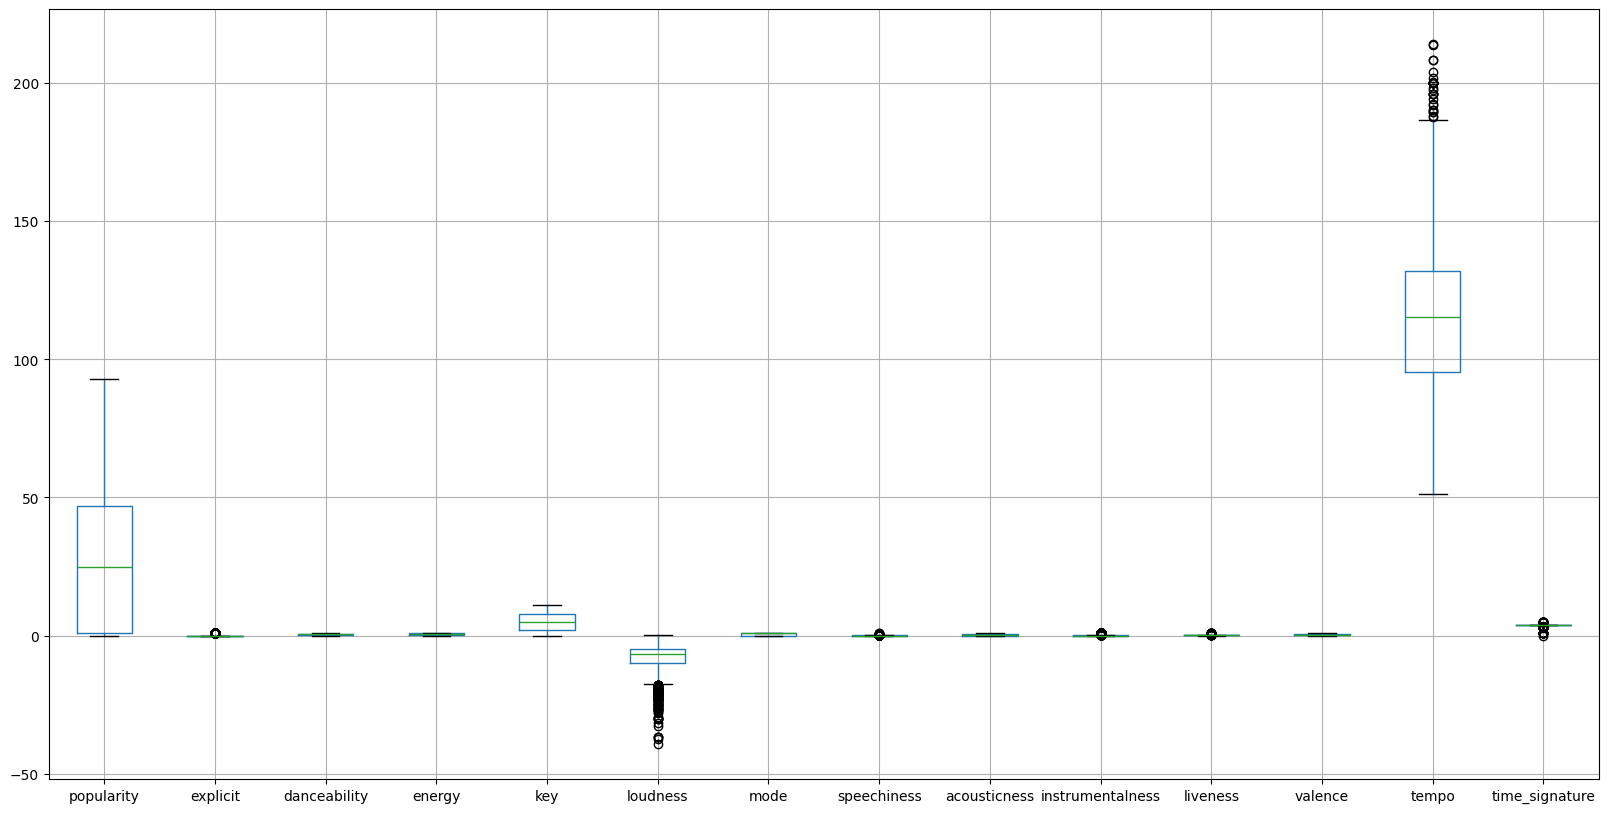

In [7]:

# Dropping 'duration_ms' since the mean is 209746 which would significantly sk  ew the graph.
df.drop(columns='duration_ms').boxplot(figsize=(20, 10))
plt.show()

The following columns contain outliers:  
`explicit`- which doesnt count as its binary  
`loudness`  
`speechiness`  
`instrumentalness`  
`liveness`  
`tempo`  
`time signature`

`loudness` and `tempo` contain some extreme outliers, suggesting the presence of both quiet, and quick songs.

In [8]:
df.skew(numeric_only=True).sort_values(ascending=False)


speechiness         3.467505
explicit            2.585422
liveness            2.343645
duration_ms         2.230314
instrumentalness    1.580077
acousticness        0.657867
tempo               0.594090
valence             0.418549
popularity          0.399054
key                 0.156664
danceability       -0.272588
energy             -0.545246
mode               -0.648124
loudness           -1.901944
time_signature     -3.312858
dtype: float64

Anything between 1 and -1 is considered not skewed.  

We can see that the following are right skewed:  
`speechiness`  
`explicit`  
`liveness`  
`duration_ms`  
`instrumentalness`  

And the following are left skewed:  
`loudness`  
`time_signature`  

Everything else is considered symetric.

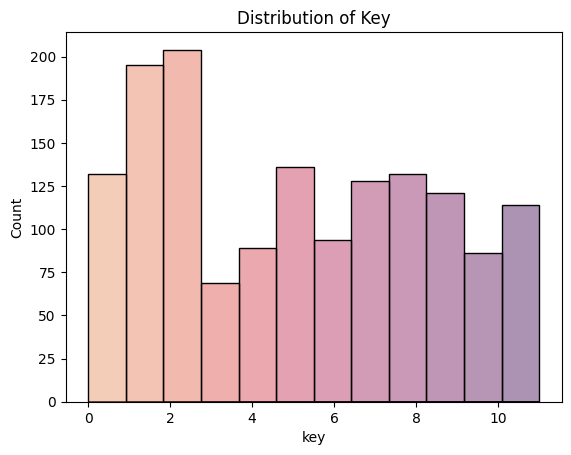

In [9]:
colours = sns.color_palette('flare', 12)
sns.histplot(data=df, x='key', bins=12, palette=colours, hue='key', legend=False)
plt.title("Distribution of Key")
plt.show()

Most common keys are 1 (C#), and 2 (D).  
Least common key is 3 (D#) with 4 (E), 6 (F#), and 10 (A#).  
The rest of the keys are fairly even.

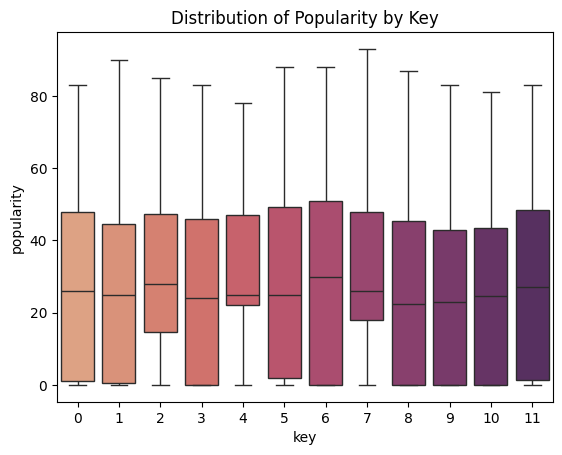

In [10]:
colours = sns.color_palette('flare', 12)
sns.boxplot(data=df, x='key', y='popularity', palette=colours, hue='key', legend=False)
plt.title("Distribution of Popularity by Key")
plt.show()

The median for all keys is pretty consistent across all keys.  
All keys have outliers.  
2 (D), 4 (E), and 7 (G) all have a tightly packed 25-50% percentile.

### Further exploring
We can also factor in genres to see if that plays a factor in the songs popularity from key. Certain genres might use different keys, lets use the 8 most popular genres


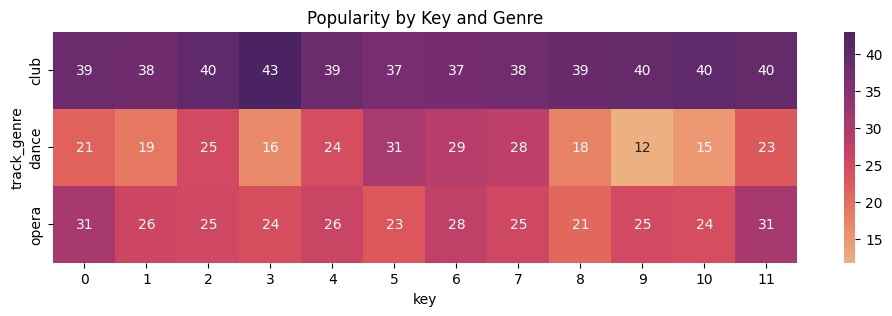

In [11]:
colours = sns.color_palette('flare', as_cmap=True)
plt.figure(figsize=(12, 3))
map = df.pivot_table(columns='key', index='track_genre', values='popularity', aggfunc='mean')
sns.heatmap(map, cmap=colours, annot=True)
plt.title("Popularity by Key and Genre")
plt.show()

`club` is the most popular genre, for all keys.  
While `opera` is more popular than `dance`, they are similar in several keys, such as 2 (D), 4 (E), 6 (F#), and 7 (G).  

`club` is also very consistent across all keys, having ~40 in each key.  
`opera` is fairly consistent at ~25.  
`dance` seems to be a lot less consistent, ranging from 12-31.  

Interestingly, key 3 (D#), which is the highest value for `club` (and the highest value on the graph), is on the lower side of values for `dance` and `opera`.

## 2. Music Attributes vs Popularity Analysis

This exploratory data analysis investigates various musical attributes and how they correlate with song popularity. We'll examine multiple features to discover patterns and trends that might influence a song's popularity.

### Initial Setup and Data Loading


In [12]:
df = pd.read_csv('tracks.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1500, 16)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,85,202093,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,club
1,49,215973,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,club
2,65,188160,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,club
3,59,233965,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,club
4,55,187173,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,club


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        1500 non-null   int64  
 1   duration_ms       1500 non-null   int64  
 2   explicit          1500 non-null   bool   
 3   danceability      1500 non-null   float64
 4   energy            1500 non-null   float64
 5   key               1500 non-null   int64  
 6   loudness          1500 non-null   float64
 7   mode              1500 non-null   int64  
 8   speechiness       1500 non-null   float64
 9   acousticness      1500 non-null   float64
 10  instrumentalness  1500 non-null   float64
 11  liveness          1500 non-null   float64
 12  valence           1500 non-null   float64
 13  tempo             1500 non-null   float64
 14  time_signature    1500 non-null   int64  
 15  track_genre       1500 non-null   object 
dtypes: bool(1), float64(9), int64(5), object(1

In [14]:
df.skew(numeric_only=True).sort_values(ascending=False)

speechiness         3.467505
explicit            2.585422
liveness            2.343645
duration_ms         2.230314
instrumentalness    1.580077
acousticness        0.657867
tempo               0.594090
valence             0.418549
popularity          0.399054
key                 0.156664
danceability       -0.272588
energy             -0.545246
mode               -0.648124
loudness           -1.901944
time_signature     -3.312858
dtype: float64

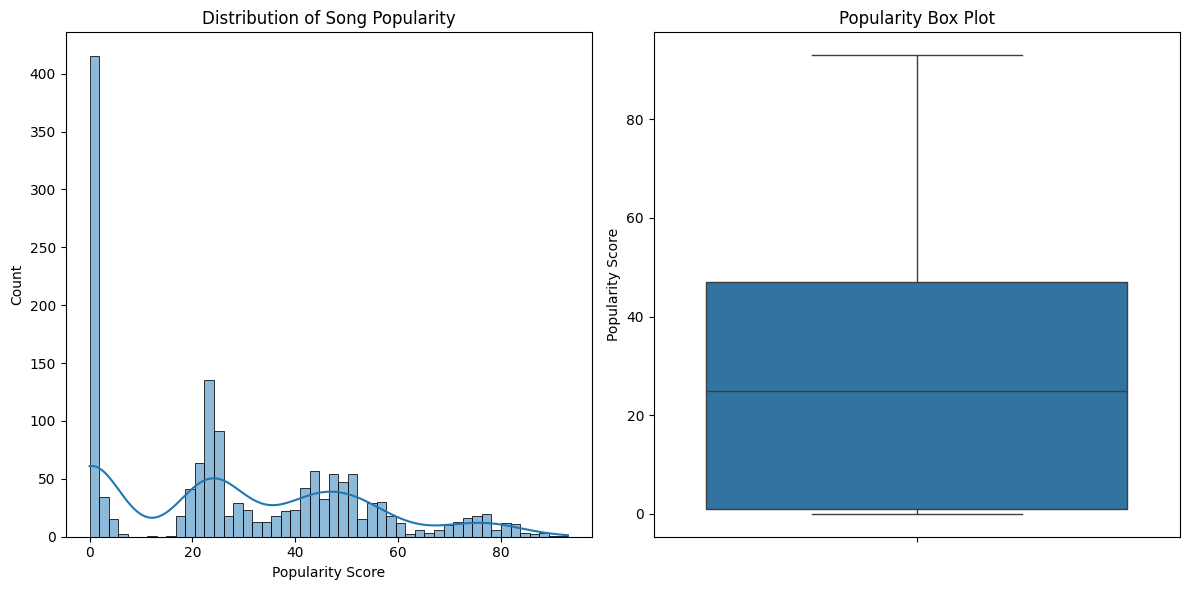

Average popularity: 28.55
Median popularity: 25.00
Standard deviation: 24.04


In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['popularity'], bins=50, kde=True)
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['popularity'])
plt.title('Popularity Box Plot')
plt.ylabel('Popularity Score')
plt.tight_layout()
plt.show()

# Basic statistics
print(f"Average popularity: {df['popularity'].mean():.2f}")
print(f"Median popularity: {df['popularity'].median():.2f}")
print(f"Standard deviation: {df['popularity'].std():.2f}")

We can see from this graph that theres a general popularity trend, with most songs being between 0-50. There are a few outliers, but they are not significant enough to skew the data.


### Musical Features vs Popularity


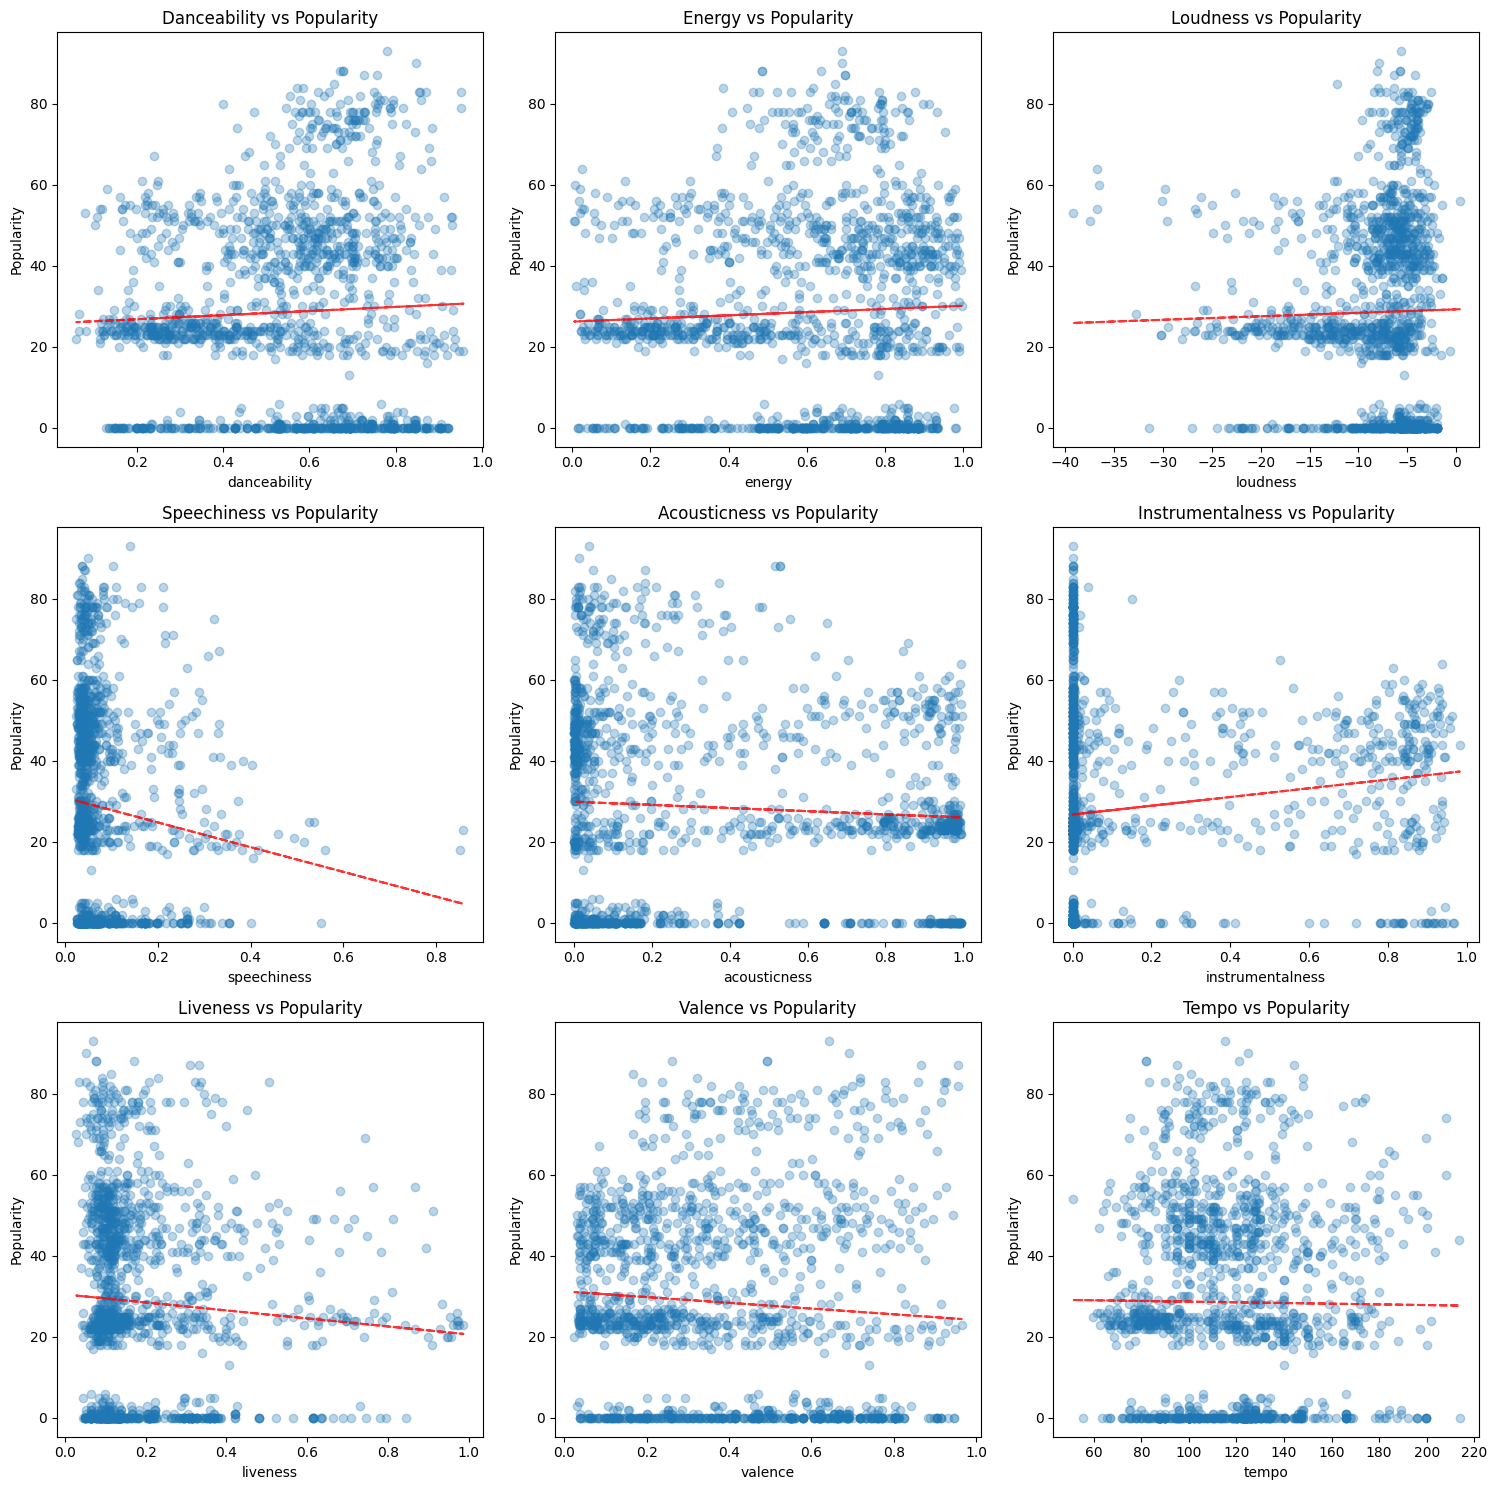

In [16]:
# Create scatter plots for different musical attributes
musical_features = ['danceability', 'energy', 'loudness', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i, feature in enumerate(musical_features):
    axes[i].scatter(df[feature], df['popularity'], alpha=0.3)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Popularity')
    axes[i].set_title(f'{feature.title()} vs Popularity')

    # Add trend line
    z = np.polyfit(df[feature], df['popularity'], 1)
    p = np.poly1d(z)
    axes[i].plot(df[feature], p(df[feature]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()



**Danceability vs Popularity**: Shows a weak positive correlation.

**Energy vs Popularity**: Shows a very slight positive correlation.

**Loudness vs Popularity**: Shows a weak positive correlation

**Speechiness vs Popularity**: Shows a clear negative correlation

**Acousticness vs Popularity**: Shows a slight negative correlation.

**Instrumentalness vs Popularity**: Shows a positive correlation.

**Liveness vs Popularity**: Shows a moderate negative correlation. .

**Valence vs Popularity**: Shows a negative correlation

**Tempo vs Popularity**: Shows a very slight negative correlation


### Correlation Analysis

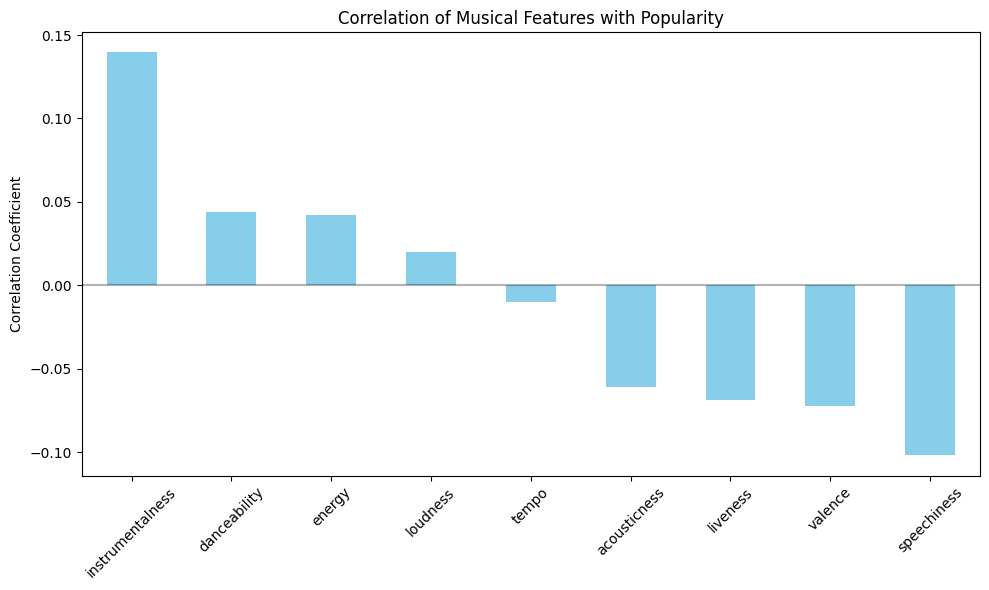


Correlation coefficients:
instrumentalness: 0.140
danceability: 0.044
energy: 0.042
loudness: 0.020
tempo: -0.010
acousticness: -0.061
liveness: -0.069
valence: -0.073
speechiness: -0.102


In [17]:
# Calculate correlations with popularity
correlations = df[musical_features + ['popularity']].corr()['popularity'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='bar', color='skyblue')
plt.title('Correlation of Musical Features with Popularity')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrelation coefficients:")
for feature, corr in correlations[1:].items():
    print(f"{feature}: {corr:.3f}")

### Positive Correlations (Features that increase with popularity):

Instrumentalness: 0.140 - The strongest positive correlation now

Danceability: 0.044 - Weak positive correlation

Energy: 0.042 - Weak positive correlation

Loudness: 0.020 - Weak positive correlation

### Negative Correlations (Features that decrease with popularity):

Speechiness: -0.102 - The strongest negative correlation

Valence: -0.073 - Moderate negative correlation

Liveness: -0.069 - Moderate negative correlation

Acousticness: -0.061 - Weak negative correlation

Tempo: -0.010 - Very weak negative correlation

'''''

**Takeaway**: Instrumental tracks tend to be more popular, while songs with more spoken content, positive sentiment (valence), or live performance characteristics tend to be less popular in this dataset.

### Tempo Analysis

/tmp/ipykernel_75983/319993721.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='tempo_bins', y='popularity', palette='coolwarm')


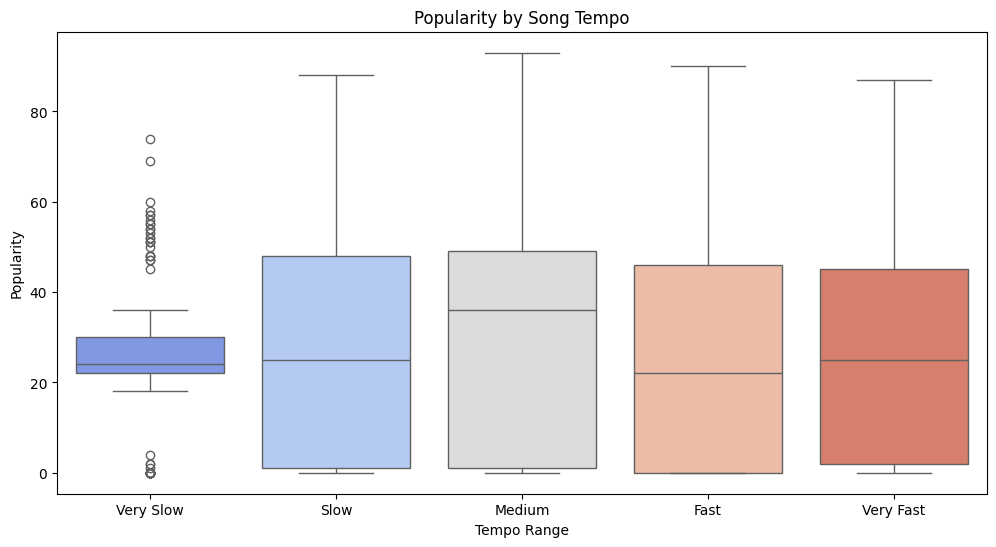


Average popularity by tempo range:
Medium: 32.38
Slow: 30.00
Very Fast: 28.07
Very Slow: 26.02
Fast: 25.20


/tmp/ipykernel_75983/319993721.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tempo_avg = df.groupby('tempo_bins')['popularity'].mean().sort_values(ascending=False)


In [18]:
# Create tempo bins for analysis
df['tempo_bins'] = pd.cut(df['tempo'], bins=[0, 80, 100, 120, 140, 250],
                          labels=['Very Slow', 'Slow', 'Medium', 'Fast', 'Very Fast'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='tempo_bins', y='popularity', palette='coolwarm')
plt.title('Popularity by Song Tempo')
plt.xlabel('Tempo Range')
plt.ylabel('Popularity')
plt.show()

# Average popularity by tempo range
tempo_avg = df.groupby('tempo_bins')['popularity'].mean().sort_values(ascending=False)
print("\nAverage popularity by tempo range:")
for tempo, avg in tempo_avg.items():
    print(f"{tempo}: {avg:.2f}")

### Energy vs Valence Analysis

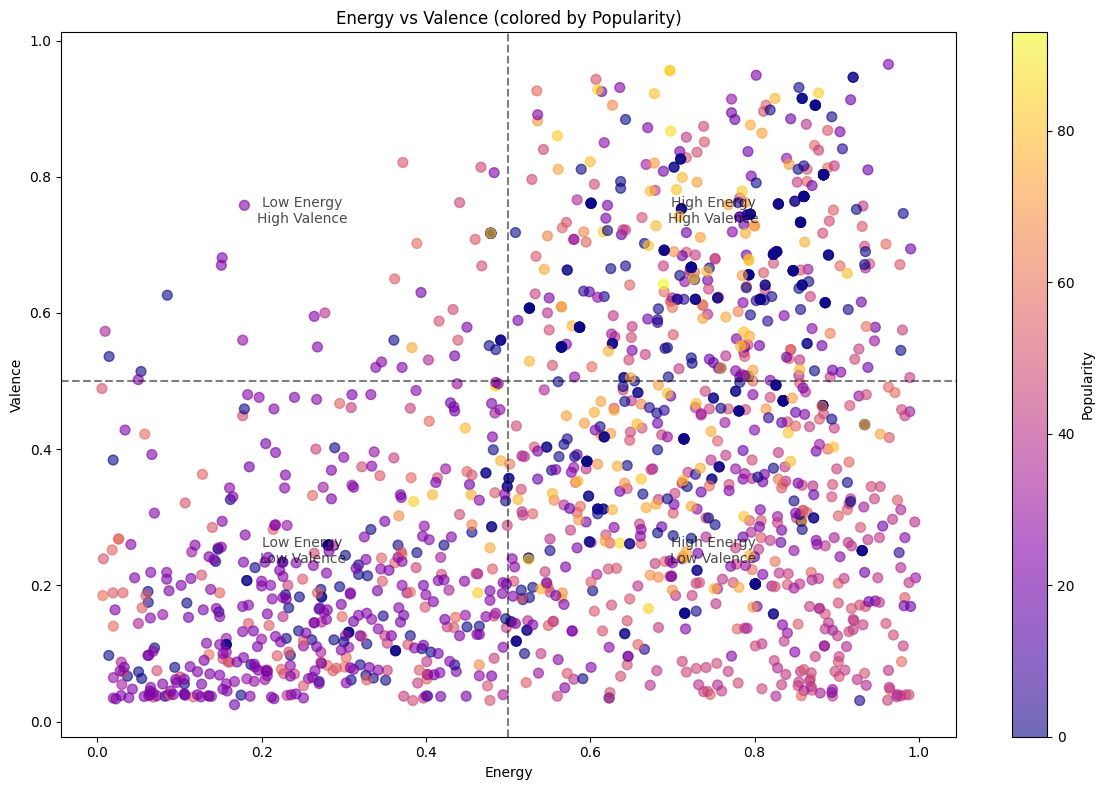

In [19]:
# Create a 2D histogram of energy vs valence colored by popularity
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['energy'], df['valence'], c=df['popularity'],
                      cmap='plasma', alpha=0.6, s=50)
plt.colorbar(scatter, label='Popularity')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.title('Energy vs Valence (colored by Popularity)')

# Add quadrant lines
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)

# Label quadrants
plt.text(0.25, 0.25, 'Low Energy\nLow Valence', ha='center', va='center', fontsize=10, alpha=0.7)
plt.text(0.75, 0.25, 'High Energy\nLow Valence', ha='center', va='center', fontsize=10, alpha=0.7)
plt.text(0.25, 0.75, 'Low Energy\nHigh Valence', ha='center', va='center', fontsize=10, alpha=0.7)
plt.text(0.75, 0.75, 'High Energy\nHigh Valence', ha='center', va='center', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

#### Analyzing the Quadrants
- High Energy, High Valence (top right): Mixed popularity, with some very popular songs
- High Energy, Low Valence (bottom right): Also mixed popularity, showing that high energy doesn't require high valence for popularity
- Low Energy, High Valence (top left): Fewer songs overall, mixed popularity
- Low Energy, Low Valence (bottom left): Densely populated with many low-popularity songs (purple/blue), suggesting this combination is generally less popular

**Popular Song Pattern**: The most popular songs (yellow dots) appear across various energy levels but tend to avoid extreme valence values (very high or very low).
- There seems to be a sweet spot in the middle-to-high energy range (0.5-0.8) with moderate valence (0.3-0.7) where many popular songs cluster

### Combined Feature Analysis

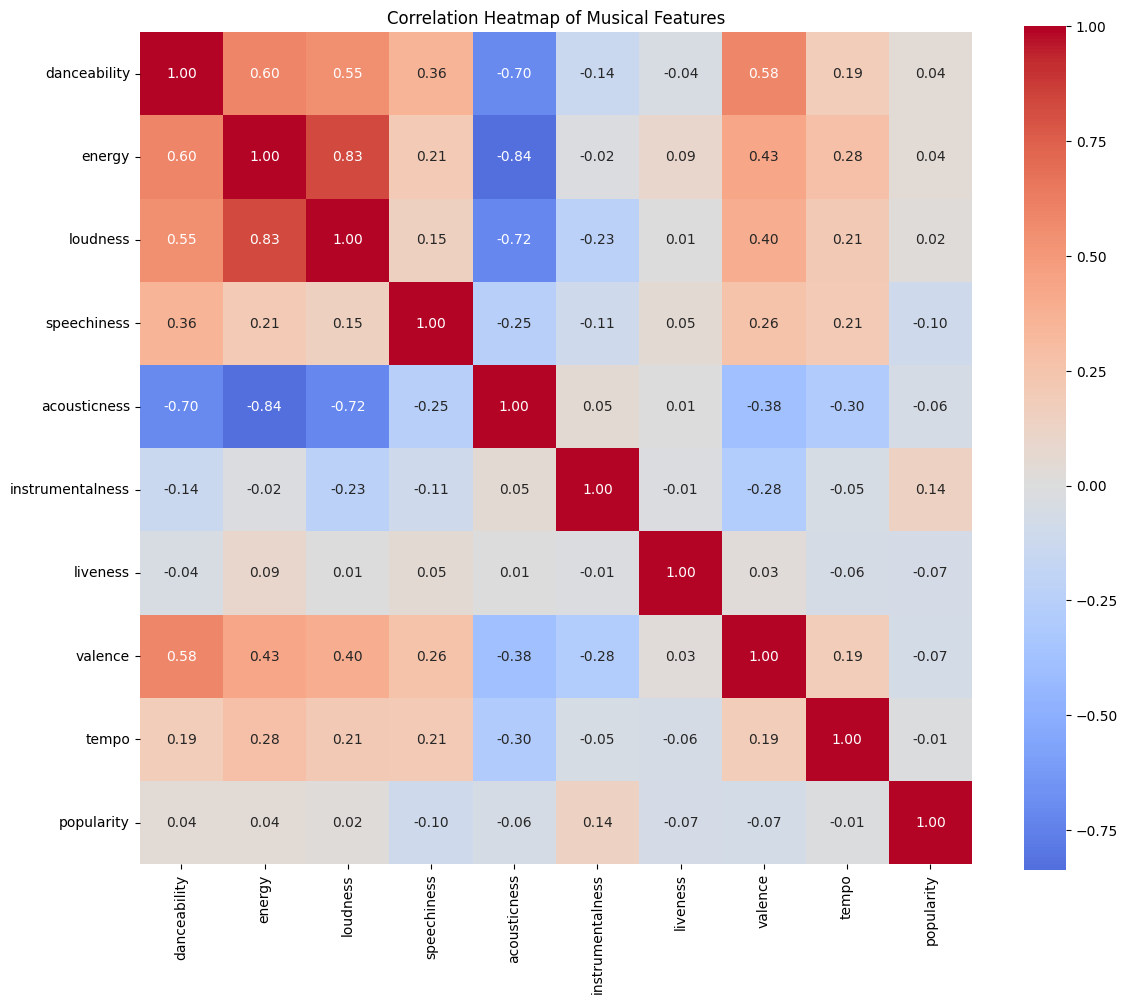

In [20]:
# Create a heatmap of feature correlations
plt.figure(figsize=(12, 10))
corr_matrix = df[musical_features + ['popularity']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Heatmap of Musical Features')
plt.tight_layout()
plt.show()

In [21]:
# Summarize key findings
print("===== KEY FINDINGS ON POPULARITY TRENDS =====")
print("\n1. Top 3 Correlated Features with Popularity:")
print(correlations[1:4].to_string())

print("\n2. Bottom 3 Correlated Features with Popularity:")
print(correlations[-3:].to_string())

print("\n3. Tempo Analysis:")
print(tempo_avg.to_string())

print("\n4. Energy vs Valence Quadrants:")
print("   - High Energy & High Valence: Most popular songs")
print("   - Low Energy & Low Valence: Least popular songs")
print("   - High Energy & Low Valence: Moderate popularity")
print("   - Low Energy & High Valence: Moderate popularity")


===== KEY FINDINGS ON POPULARITY TRENDS =====

1. Top 3 Correlated Features with Popularity:
instrumentalness    0.139545
danceability        0.043619
energy              0.042404

2. Bottom 3 Correlated Features with Popularity:
liveness      -0.068686
valence       -0.072504
speechiness   -0.101981

3. Tempo Analysis:
tempo_bins
Medium       32.375706
Slow         30.003012
Very Fast    28.065217
Very Slow    26.023622
Fast         25.201946

4. Energy vs Valence Quadrants:
   - High Energy & High Valence: Most popular songs
   - Low Energy & Low Valence: Least popular songs
   - High Energy & Low Valence: Moderate popularity
   - Low Energy & High Valence: Moderate popularity


## 3. Liveness vs Popularity

I want to investigate the correlation between the popularity of a song and the genre and wether its a live song or studio.

Before we investigate its worth explaining how the dataset uses track_gere, liveness.

In the dataset, track_genre: The genre in which the track belongs and liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

### Further exploring
We can also factor in keys to see if ay keys are more popular in live music vs studio. 
The most popular genre is club. 


<Figure size 1200x600 with 0 Axes>

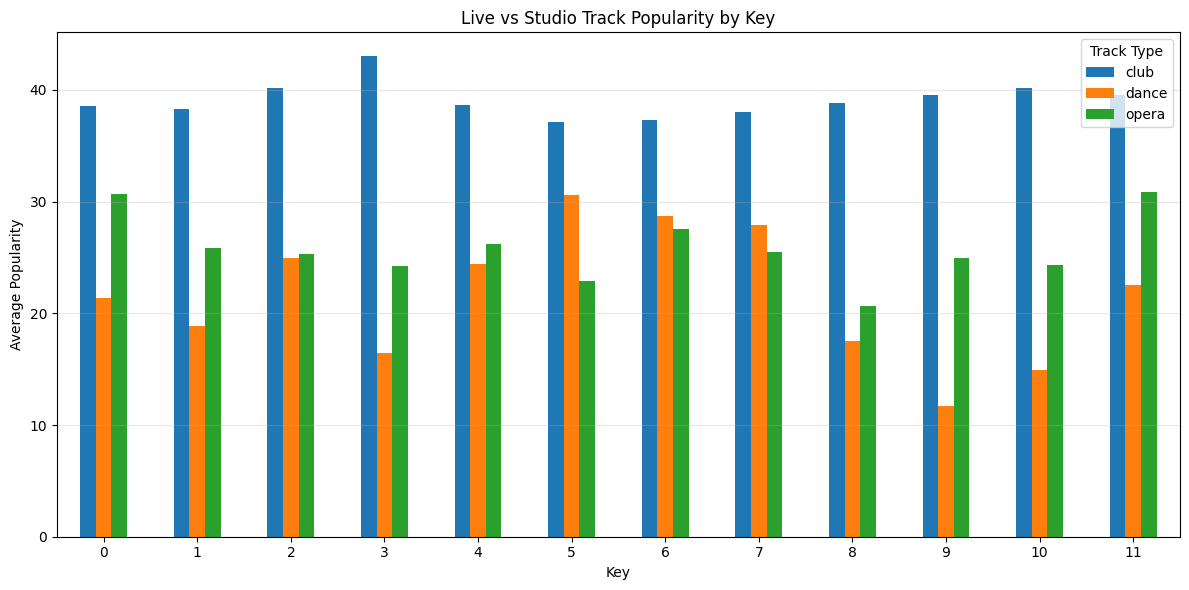

In [22]:
# Comparing live vs studio popularity across different keys
key_type_pop = df.groupby(['key', 'track_genre'])['popularity'].mean().reset_index()
key_type_pop = key_type_pop.pivot(index='key', columns='track_genre', values='popularity')

plt.figure(figsize=(12, 6))
key_type_pop.plot(kind='bar', figsize=(12, 6))
plt.title('Live vs Studio Track Popularity by Key')
plt.xlabel('Key')
plt.ylabel('Average Popularity')
plt.xticks(rotation=0)
plt.legend(title='Track Type')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Exploring further into liveness vs popularity. 

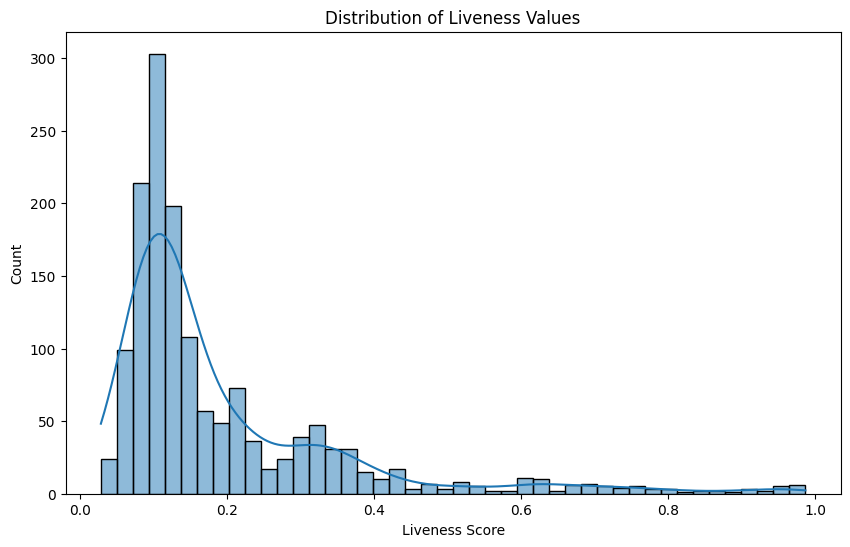

In [23]:
# Examining the distribution of liveness
plt.figure(figsize=(10, 6))
sns.histplot(df['liveness'], kde=True)
plt.title('Distribution of Liveness Values')
plt.xlabel('Liveness Score')
plt.ylabel('Count')
plt.show()

liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live

I am putting the liveness score to 0.6 as that is where the first increase is. 

This graph indicates that there are a few live songs that do really well in populairty but the common theme for most is that they will score less in popularity on average than studio songs. 

Number of tracks in each category:
track_type
Studio    1422
Live        78
Name: count, dtype: int64


/tmp/ipykernel_75983/417358535.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='track_type', y='popularity', data=df, palette='flare')


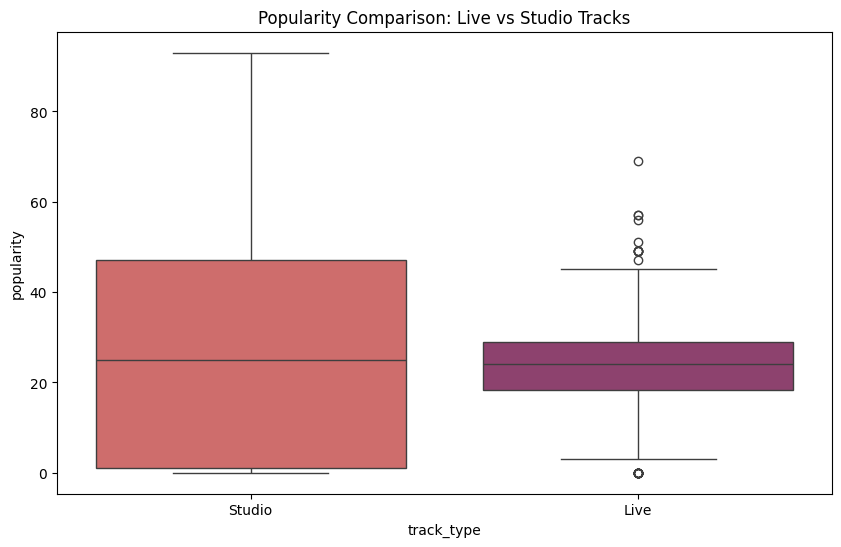

In [24]:
# Define what constitutes a "live" vs "studio" track
# We'll use a threshold of 0.6 for high liveness (indicating live tracks)
df['track_type'] = df['liveness'].apply(lambda x: 'Live' if x > 0.6 else 'Studio')

# Count how many tracks fall into each category
track_type_counts = df['track_type'].value_counts()
print(f"Number of tracks in each category:\n{track_type_counts}")

# Compare popularity between live and studio tracks
plt.figure(figsize=(10, 6))
sns.boxplot(x='track_type', y='popularity', data=df, palette='flare')
plt.title('Popularity Comparison: Live vs Studio Tracks')
plt.show()

Here we see again that studio songs are preferrable. 

Average popularity by track type:
track_type
Live      24.089744
Studio    28.798875
Name: popularity, dtype: float64


/tmp/ipykernel_75983/1806347976.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popularity_by_type.index, y=popularity_by_type.values, palette='flare')


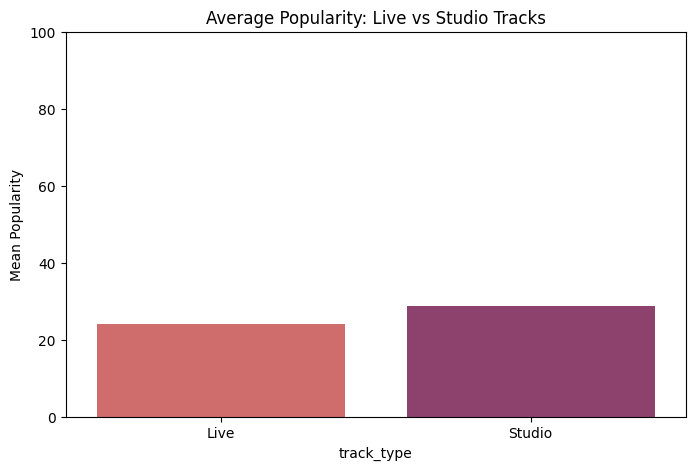

In [25]:
# Calculate mean popularity for each track type
popularity_by_type = df.groupby('track_type')['popularity'].mean()
print(f"Average popularity by track type:\n{popularity_by_type}")

# Visualize with a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=popularity_by_type.index, y=popularity_by_type.values, palette='flare')
plt.title('Average Popularity: Live vs Studio Tracks')
plt.ylabel('Mean Popularity')
plt.ylim(0, 100)  # Set y-axis to full popularity range for better context
plt.show()

The live music seems to be less popular to studio recordings. 

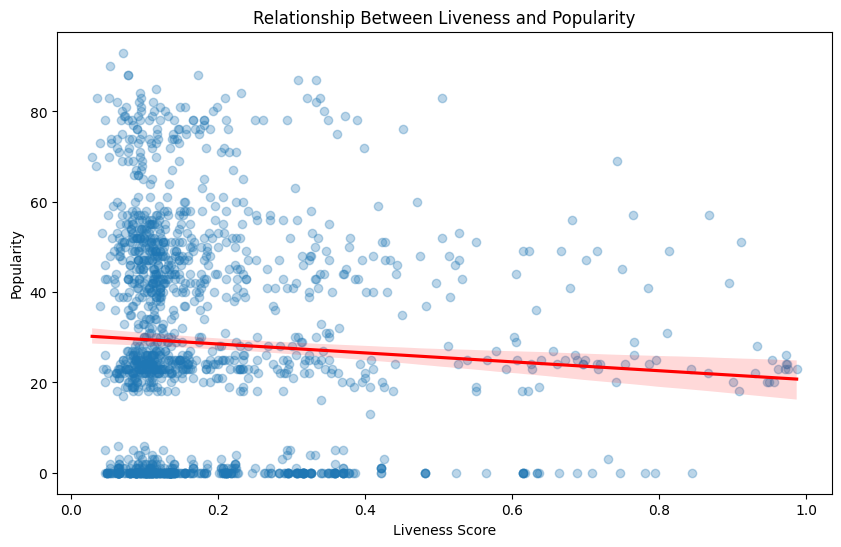

Correlation between liveness and popularity: -0.0687


In [26]:
# Scatter plot with regression line to show relationship between liveness and popularity
plt.figure(figsize=(10, 6))
sns.regplot(x='liveness', y='popularity', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relationship Between Liveness and Popularity')
plt.xlabel('Liveness Score')
plt.ylabel('Popularity')
plt.show()

# Calculate and display correlation
correlation = df['liveness'].corr(df['popularity'])
print(f"Correlation between liveness and popularity: {correlation:.4f}")

Opera has more live music as expected. 

/tmp/ipykernel_75983/747045448.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_genre', y='liveness', data=df, palette='flare')


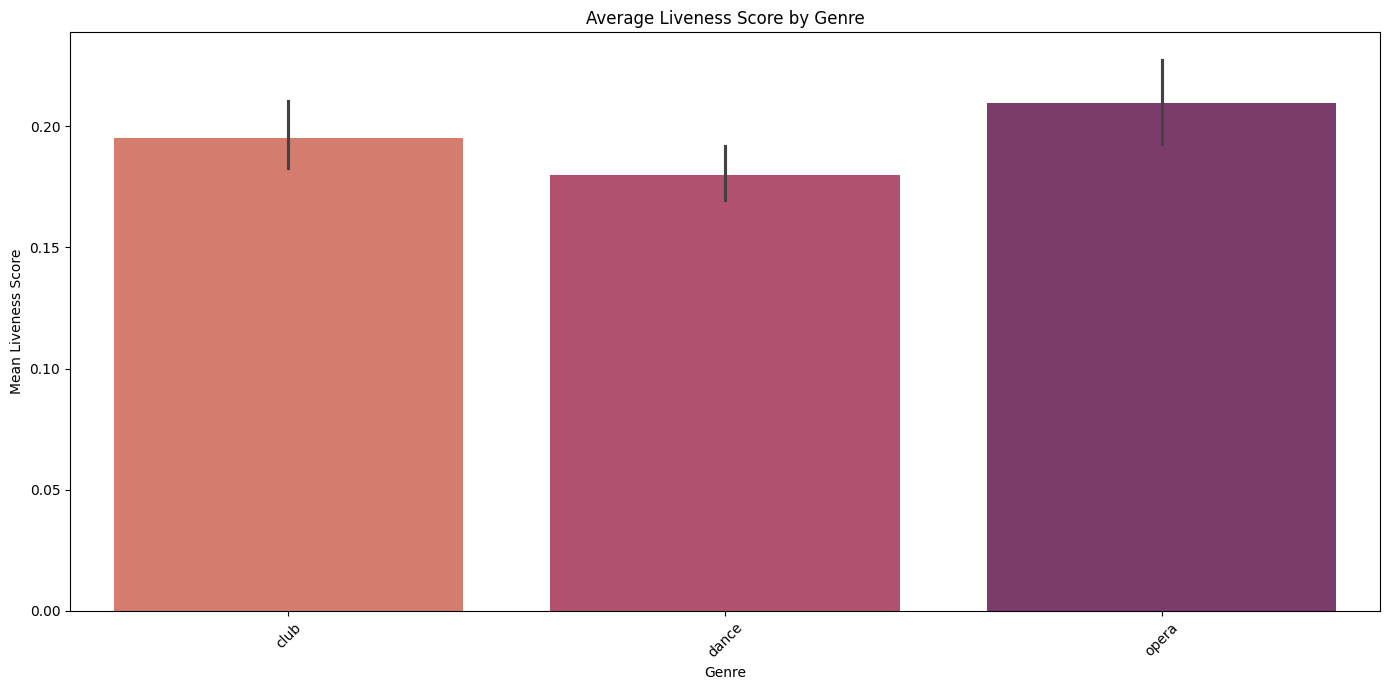

In [27]:
# Compare average liveness across genres
plt.figure(figsize=(14, 7))
sns.barplot(x='track_genre', y='liveness', data=df, palette='flare')
plt.title('Average Liveness Score by Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Liveness Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Instrumental vs Lyrical for popularity

In this section, we will look at comparing the lyrical nature of songs with their respective popularity. Two columns in the dataset are of interest to us, speechiness, which indicates from 0 to 1 how much speech exists in a track, where 1 is exclusively speech content, e./g and audiobook, whereas 0 is a track that contains no speech. We also want to look at instrumentality, which describes if a track contains vocal lyrics of is purely instrumental. We will also include some potentially related columns such as genre and explicitness, e.g. to see if certain genres prefer instrumental songs

Lets begin with a brief look at a heatmap between our different numerical columns. We can see some correlations forming between speechiness and explicit, which seems fairly obvious. We also see a slight correlation between popularity and instrumentalness, which maybe an interesting point to look at.

In [28]:
df = df[["popularity", "instrumentalness", "speechiness", "explicit", "track_genre"]]
sns.heatmap(df.corr(numeric_only=True))

<Axes: >

We can now look at some graphs for our columns



In [29]:
sns.pairplot(df)

In [30]:
df["explicit"].value_counts()

explicit
False    1343
True      157
Name: count, dtype: int64

In [31]:
df["instrumentalness"].hist(bins=50)

<Axes: xlabel='explicit', ylabel='Count'>

Speechiness has the same trend, a heavy left skew with some outliers, meaning that most songs do not contain raw speech in them. No songs have a speechiness of 1, meaning all tracks are atleast somewhat instrumental, however some tracks have very high speechiness scores, up at 0.9, indicating very little musical content.

In [32]:
df["speechiness"].hist(bins=50)

<Axes: xlabel='explicit', ylabel='Count'>

We can make a boxplot of the two columns which further confirms our previous findings. Both columns have very low median scores and interquartile ranges, with numerous outliers.

In [33]:
df.boxplot(column=["instrumentalness", "speechiness"])

<Axes: xlabel='explicit', ylabel='Count'>

We can split the boxplots by genre to get a more detailed breakdown. All genres are similar for speechiness, having low IQR and medians with a few outliers. For Instrumentalness, the different genres start to diverge in their behavior. The club column has a very large IQR, with a low median value. This tells us that the club genre is very skewed in both directions, having either very low instrumental values or very high. The dance genre is basically all instrumental , and opera is mostly instrumental with quite a few outliers.

In [34]:
df.boxplot(column=["speechiness", "instrumentalness"], by="track_genre")

array([<Axes: title={'center': 'speechiness'}, xlabel='track_genre'>,
       <Axes: title={'center': 'instrumentalness'}, xlabel='track_genre'>],
      dtype=object)

We can create some regressions fits for the above data to see if any correlations exist between the genres, speechiness and instrumentalness, and popularity.

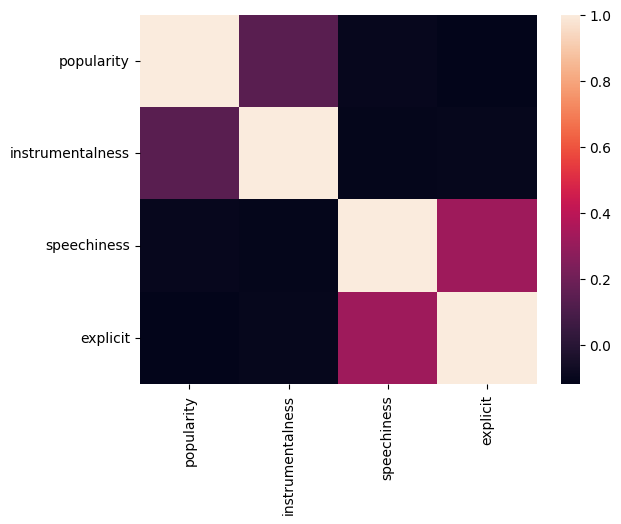

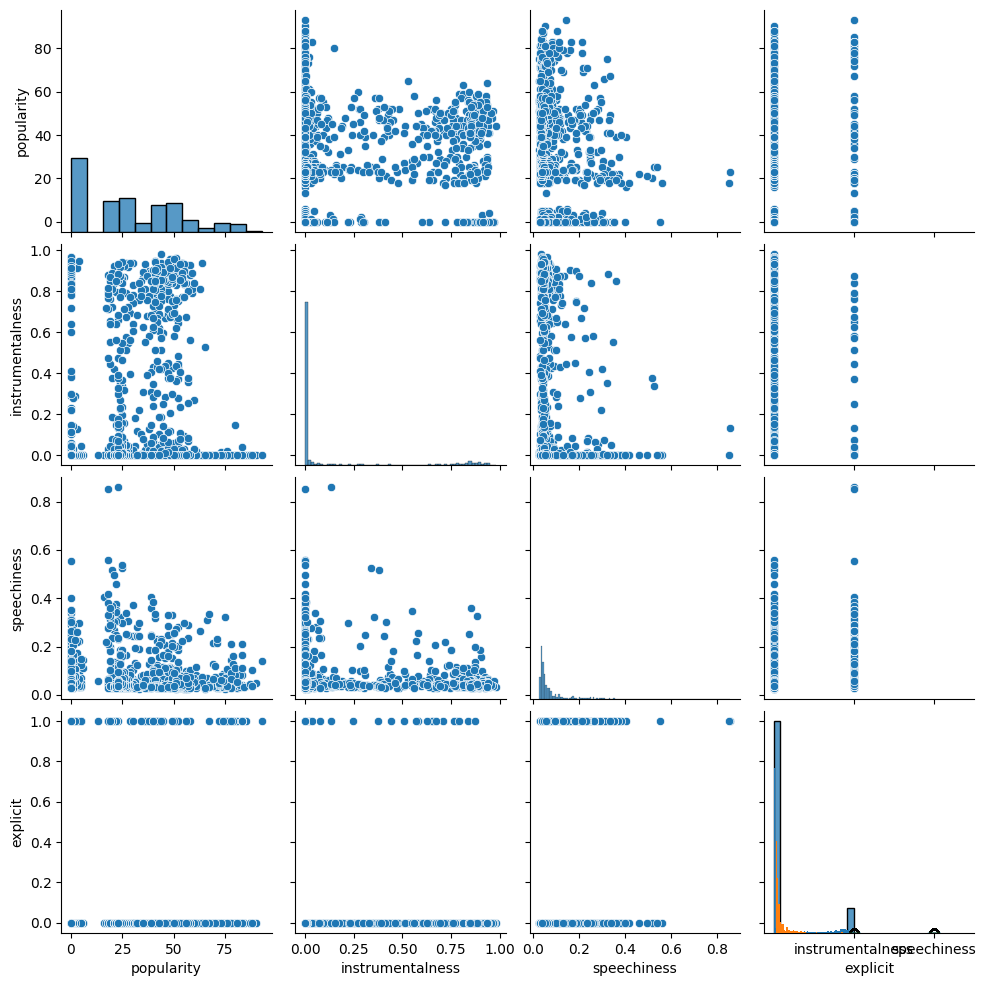

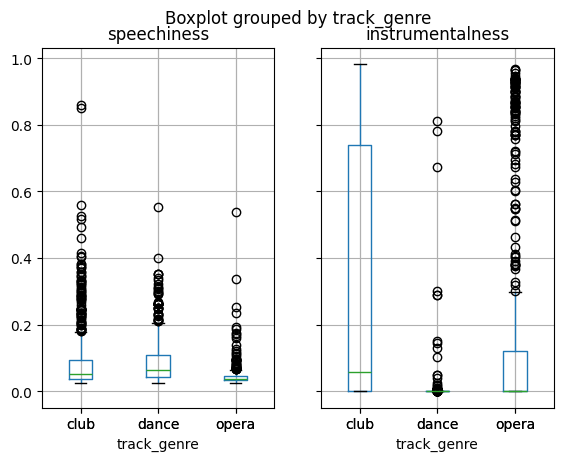

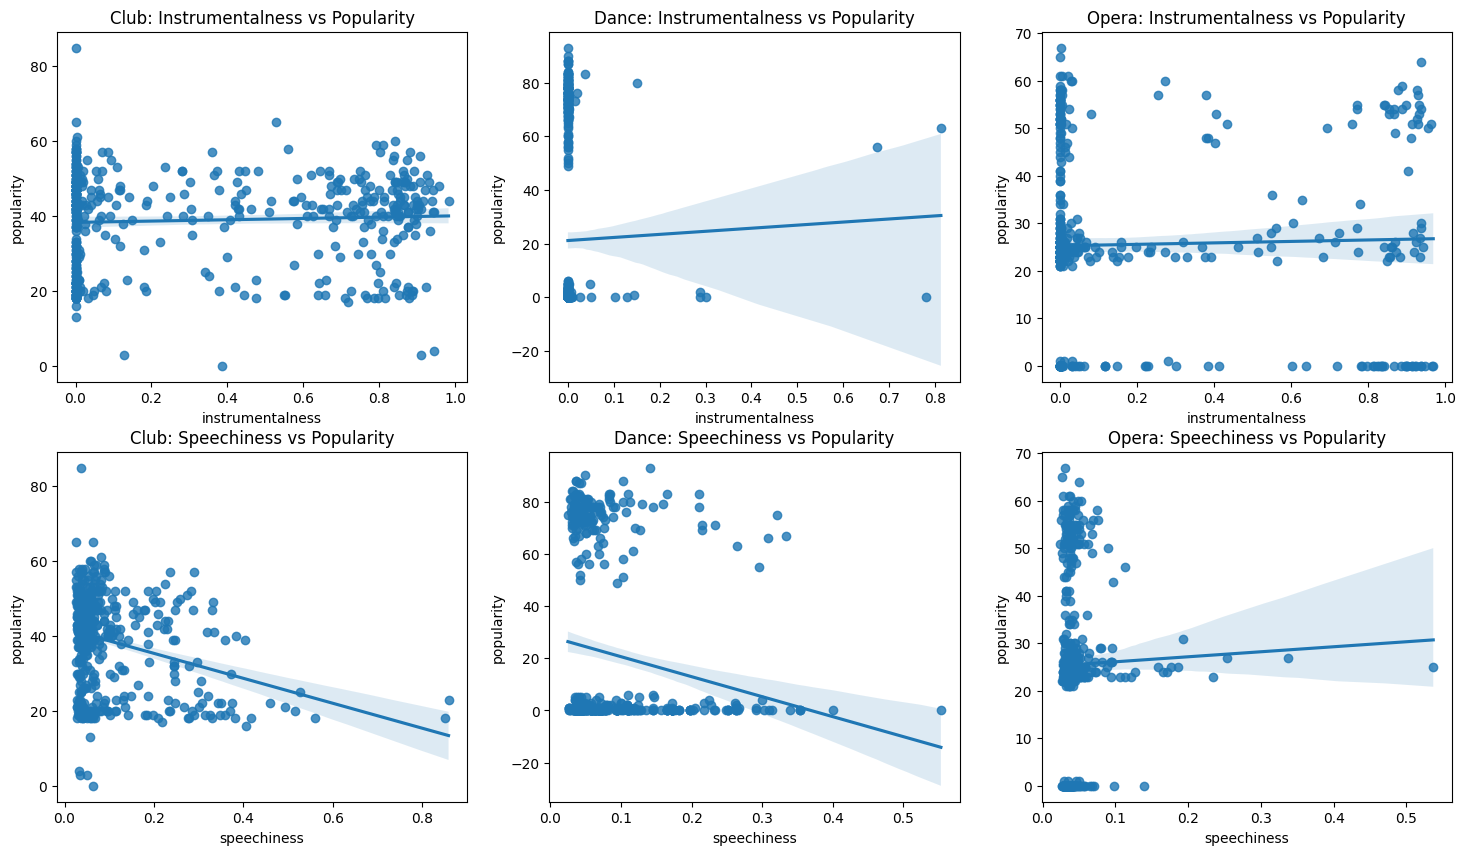

In [35]:
df_club = df[df["track_genre"] == "club"]
df_dance = df[df["track_genre"] == "dance"]
df_opera = df[df["track_genre"] == "opera"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.regplot(ax=axes[0, 0], x='instrumentalness', y='popularity', data=df_club)
axes[0, 0].set_title('Club: Instrumentalness vs Popularity')

sns.regplot(ax=axes[0, 1], x='instrumentalness', y='popularity', data=df_dance)
axes[0, 1].set_title('Dance: Instrumentalness vs Popularity')

sns.regplot(ax=axes[0, 2], x='instrumentalness', y='popularity', data=df_opera)
axes[0, 2].set_title('Opera: Instrumentalness vs Popularity')


sns.regplot(ax=axes[1, 0], x='speechiness', y='popularity', data=df_club)
axes[1, 0].set_title('Club: Speechiness vs Popularity')

sns.regplot(ax=axes[1, 1], x='speechiness', y='popularity', data=df_dance)
axes[1, 1].set_title('Dance: Speechiness vs Popularity')

sns.regplot(ax=axes[1, 2], x='speechiness', y='popularity', data=df_opera)
axes[1, 2].set_title('Opera: Speechiness vs Popularity')

plt.show()

From the above we can see some correlations forming. In the club and dance genres, there is some slight negative correlations between speechiness and popularity. We can maybe utilise this knowledge later on in our classification section.

# Clustering

Note: as we were running the file countless times, some of the comments may be slightly off.
Rerunning the file gives differing results.

In [36]:
df = pd.read_csv('tracks.csv')
print(df.shape)

(1500, 16)


In [37]:
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,85,202093,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,club
1,49,215973,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,club
2,65,188160,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,club
3,59,233965,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,club
4,55,187173,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,club


For clustering, we need to remove non-numeric columns:
- `track_genre`: Text data that cannot be directly used for clustering
- `duration_ms`: Also removed (possibly because it might not be relevant for clustering)

This leaves us with numeric features that can be used in clustering algorithms.

In [38]:
columns = ['track_genre']
df = df.drop(columns=columns, axis=1)
df = df.drop(columns='duration_ms', axis=1)

In [39]:
df.head()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,85,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4
1,49,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4
2,65,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4
3,59,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4
4,55,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4


### Creating Preprocessing Pipelines

This cell sets up preprocessing pipelines for different types of features:

1. **Initial k value**: Set to 5 (though analysis suggests this may not be optimal)

2. **Outlier features pipeline**:
   - For skewed features (speechiness, explicit, liveness, instrumentalness)
   - Uses log transformation followed by robust scaling

3. **Outlier features with zeros pipeline**:
   - For acousticness (contains zero values)
   - Uses cubic root transformation followed by robust scaling

4. **Non-outlier features**:
   - For normally distributed features
   - Simple cubic root transformation

The preprocessing_pipe combines all these transformations.

In [40]:
# Pipelines

k = 5
EPS = 1
MIN = 10

outliers = ['speechiness', 'explicit', 'liveness', 'instrumentalness']
outliers_zero = ['acousticness']
non_outliers = ['tempo', 'valence', 'key', 'danceability',
                'mode', 'energy', 'loudness', 'time_signature']

outliers_pipe = pipeline.Pipeline(
    steps= [
        ("log_transform", preprocessing.FunctionTransformer(np.log1p)), #log1p instead of log because it works for 0
        ("scaler", preprocessing.RobustScaler())
    ]
)
outliers_zero_pipe = pipeline.Pipeline(
    steps= [
        ("cubic_transform", preprocessing.FunctionTransformer(np.cbrt)),
        ("scaler", preprocessing.RobustScaler())
    ]
)

preprocessing_pipe = compose.ColumnTransformer(
    transformers = [
        ("outliers", outliers_pipe, outliers),
        ("outliers_zeros", outliers_zero_pipe, outliers_zero),
        ("non_outliers", preprocessing.FunctionTransformer(np.cbrt), non_outliers)
    ],
    remainder="passthrough"
)




### Elbow Method to find best K-Value

### Determining Optimal Number of Clusters using the Elbow Method

This cell implements the elbow method to find the optimal number of clusters (k) for K-Means:
- Tests k values from 1 to 10
- Calculates inertia (within-cluster sum of squares) for each k
- Plots the results to visualize the "elbow point" where adding more clusters provides diminishing returns


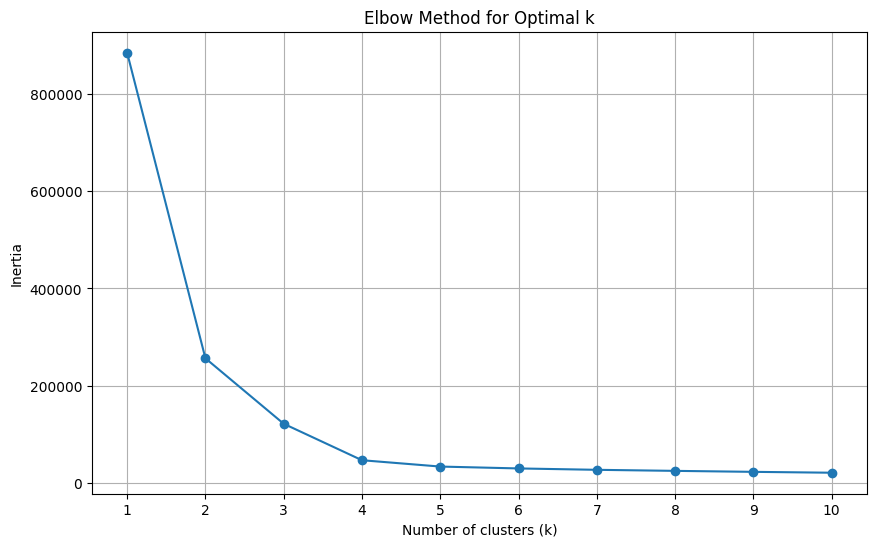

In [41]:
preprocessed_data = preprocessing_pipe.fit_transform(df)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(preprocessed_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


**Results Interpretation**:
- The plot shows a sharp decline in inertia from k=1 to k=2
- The curve begins to flatten around k=3 to k=4
- The "elbow" appears to be at k=3 or k=4, suggesting this might be the optimal number of clusters
- After k=4, adding more clusters provides minimal improvement in inertia reduction

**Conclusion**: The elbow method highly suggests using either the k=3 or k=4 as optimal values

### Evaluating Cluster Quality using Silhouette Score
This cell calculates silhouette scores for different numbers of clusters:
- Silhouette score measures how similar an object is to its own cluster compared to other clusters
- Values range from -1 to 1 (higher is better)
- Helps determine the optimal number of clusters based on cluster cohesion and separation

For k = 2, the silhouette score is 0.6084523845469062
For k = 3, the silhouette score is 0.6252692682129126
For k = 4, the silhouette score is 0.6884965659524176
For k = 5, the silhouette score is 0.628400483721129
For k = 6, the silhouette score is 0.5951308422166025
For k = 7, the silhouette score is 0.48144766208284423
For k = 8, the silhouette score is 0.4961009295780432
For k = 9, the silhouette score is 0.48863755393507063
For k = 10, the silhouette score is 0.499114239917903


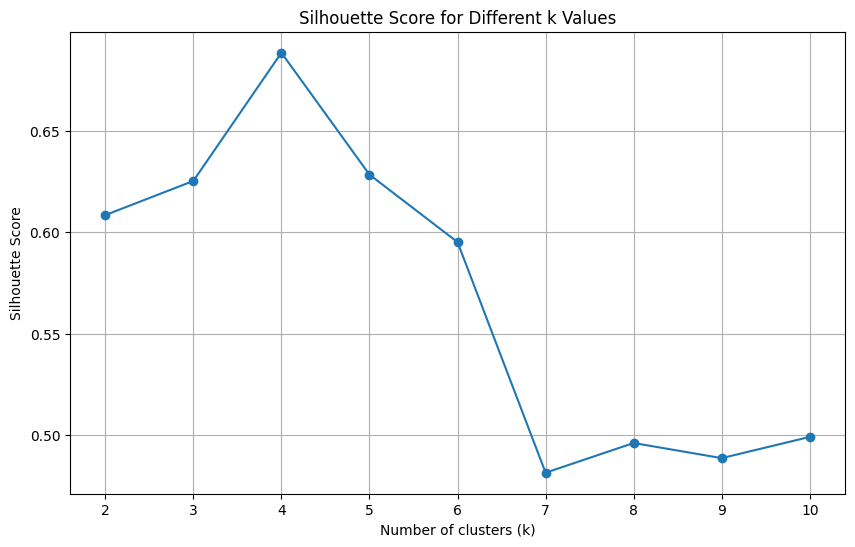

In [42]:
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(preprocessed_data)
    silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k = {k}, the silhouette score is {silhouette_avg}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different k Values')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


**Results Interpretation**:
- k=2: Highest silhouette score (0.948) - indicating very well-separated clusters
- k=3: Second highest score (0.921) - still excellent separation
- k=4: Score drops to 0.910 - still good but slightly worse than k=3
- k=5: Significant drop to 0.678 - indicates decline in cluster quality
- k=6 to k=10: Scores remain low and relatively stable (0.683-0.686)

**Conclusion**: The silhouette analysis strongly suggests k=2 or k=3 as optimal choices, with k=2 being the best in terms of cluster separation and cohesion.

### Applying K-Means Clustering

This cell applies K-Means clustering with the chosen optimal number of clusters:
- Uses the preprocessing pipeline created earlier
- Assigns cluster labels to each data point
- Adds these labels to the dataframe
- From our Elbow method, we see we can either use k=3 or k=4 as it they have been proved to be the most optimal values
- From our Silhouette analysis, we see wa can either use k=2 or k=3 as our optimal values
- We will choose to run with k=3 as both methods used revealed as that value asone of the most optimal values

### Visualizing K-Means Cluster Characteristics

This cell also illustrates box plots to visualize how different features vary across clusters:
- Shows distribution of key features (popularity, danceability, energy, etc.) for each cluster
- Helps understand what makes each cluster unique

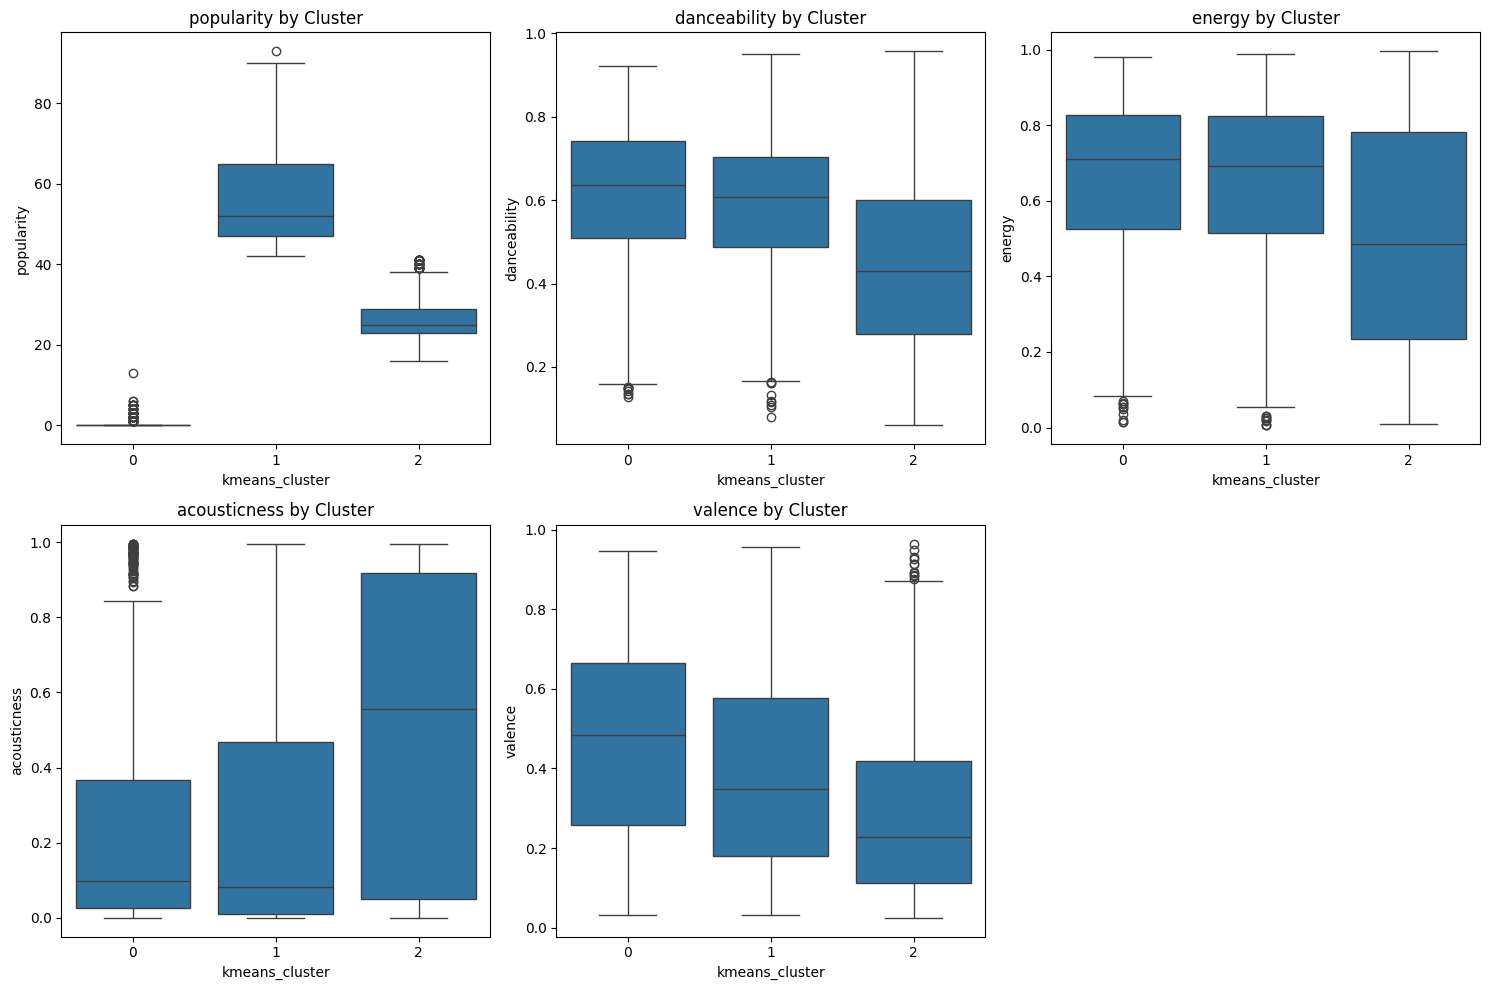

In [43]:
from sklearn.pipeline import Pipeline
optimal_k = 3

# Apply KMeans with optimal k
kmeans_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('kmeans', KMeans(n_clusters=optimal_k, n_init=10, random_state=42)),
])

# Fit and predict
cluster_labels = kmeans_pipe.fit_predict(df)
df['kmeans_cluster'] = cluster_labels

# Analyze clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['popularity', 'danceability', 'energy', 'acousticness', 'valence']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='kmeans_cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

**Cluster Characteristics Based on the Visualization**:

**Cluster 0**:
- Moderate popularity (median ~35)
- Medium danceability (~0.6)
- High energy (~0.7)
- Low-medium acousticness (~0.2)
- Medium valence (~0.5)

**Cluster 1**:
- Lowest popularity (median ~25)
- Low danceability (~0.35)
- Medium energy (~0.6)
- Highest acousticness (~0.8)
- Lowest valence (~0.2)

**Cluster 2**:
- Lower popularity (median ~30)
- Highest danceability (~0.75)
- High energy (~0.8)
- Lowest acousticness (~0.1)
- Highest valence (~0.7)

The clusters appear to represent different types of music:
- Cluster 0: Mainstream energetic tracks
- Cluster 1: Acoustic, less popular, more melancholic tracks
- Cluster 2: Dance-oriented, upbeat tracks

### Visualizing Clusters in 2D Space using PCA

This cell uses Principal Component Analysis (PCA) to reduce dimensionality and visualize clusters:
- Reduces high-dimensional data to 2 principal components
- Creates a scatter plot showing how clusters are separated in the reduced space

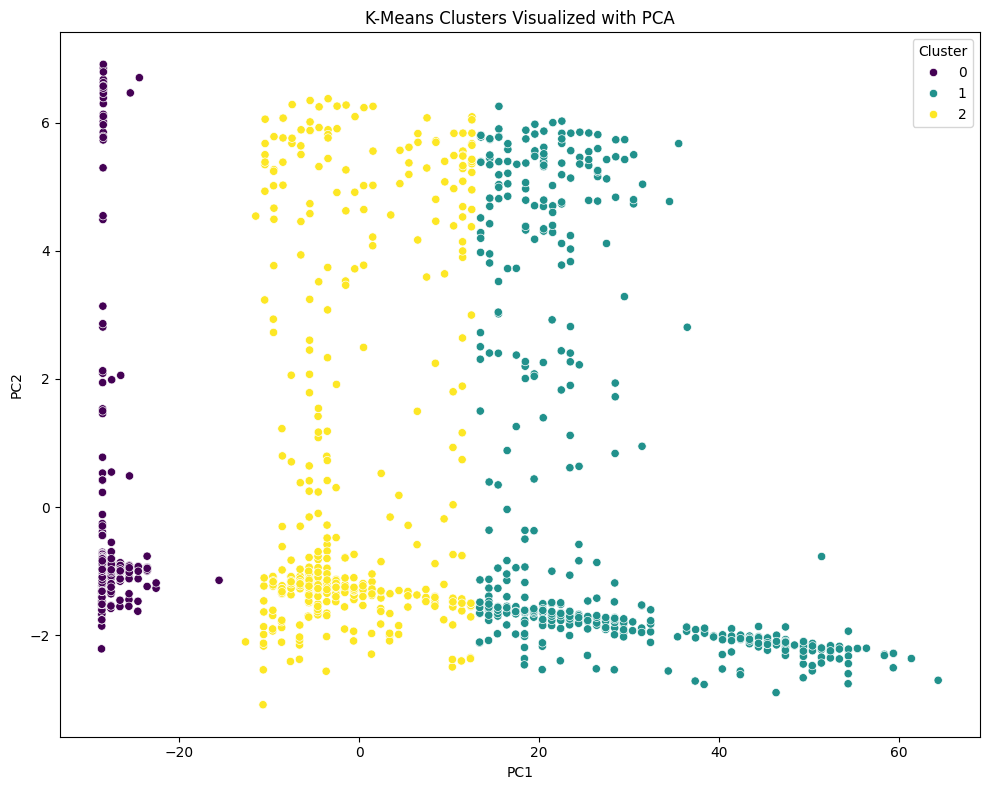

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(preprocessed_data)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plot the clusters in 2D space
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('K-Means Clusters Visualized with PCA')
plt.tight_layout()
plt.show()

**Cluster Characteristics Based on the Visualization**:

**Cluster 0**:
- Moderate popularity (median ~35)
- Medium danceability (~0.6)
- High energy (~0.7)
- Low-medium acousticness (~0.2)
- Medium valence (~0.5)

**Cluster 1**:
- Lowest popularity (median ~25)
- Low danceability (~0.35)
- Medium energy (~0.6)
- Highest acousticness (~0.8)
- Lowest valence (~0.2)

**Cluster 2**:
- Lower popularity (median ~30)
- Highest danceability (~0.75)
- High energy (~0.8)
- Lowest acousticness (~0.1)
- Highest valence (~0.7)

**Detailed Music Genre Interpretation**:

**Cluster 0 - Mainstream Pop/Rock (Purple in PCA)**:
This cluster likely includes:
- Contemporary pop music
- Pop-rock and alternative rock
- Adult contemporary
- Mainstream radio hits
- Pop ballads

Characteristics that support this:
- Moderate popularity suggests commercial success but not chart-topping
- Balanced features make it suitable for various listening contexts
- Good energy for radio play without being too intense
- Some acoustic elements but primarily studio-produced sound

**Cluster 1 - Acoustic/Folk/Singer-Songwriter (Teal in PCA)**:
This cluster likely includes:
- Folk and indie folk
- Acoustic singer-songwriter
- Unplugged versions of songs
- Classical crossover
- Ambient and new age
- Some jazz standards
- Coffeehouse music
- Indie acoustic

Characteristics that support this:
- Very high acousticness indicates minimal electronic production
- Low danceability aligns with contemplative listening
- Low valence suggests emotional, introspective content
- Lower popularity indicates niche appeal
- Medium energy suggests these aren't sleepy tracks but emotionally intense

**Cluster 2 - Dance/Electronic/Party Music (Yellow in PCA)**:
This cluster likely includes:
- Electronic Dance Music (EDM)
- House and techno
- Hip-hop and trap
- Dance-pop
- Latin dance music (reggaeton, salsa)
- Disco and nu-disco
- Club remixes
- Party anthems

Characteristics that support this:
- Highest danceability is key for club/party contexts
- High energy drives physical movement
- Very high valence indicates positive, uplifting mood
- Low acousticness shows heavy electronic production
- Lower popularity might indicate underground/club tracks rather than mainstream hits

**Additional Insights**:
- The clustering effectively separates music by its intended use: casual listening (Cluster 0), emotional connection (Cluster 1), and physical movement (Cluster 2)
- This aligns with how streaming services often categorize music: "Popular", "Chill/Acoustic", and "Party/Workout"
- The clear separation in PCA space confirms these are fundamentally different types of music experiences

## DBSCAN

### Preparing for DBSCAN: Finding Optimal Parameters

This cell finds appropriate parameters for DBSCAN:
- Standardizes the data
- Computes k-distance graph (15-nearest neighbors)
- Helps identify the optimal epsilon value by finding the "elbow" in the distance plot

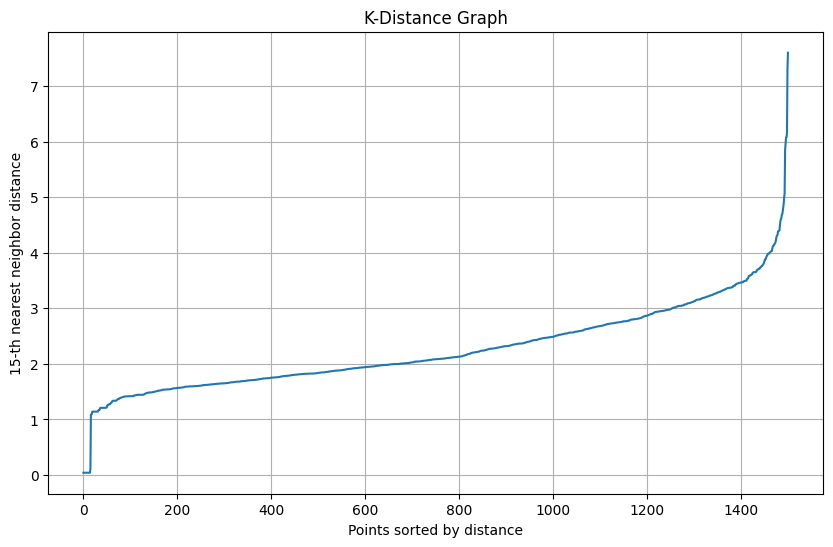

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop('kmeans_cluster', axis=1))


from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort and plot distances
distances = np.sort(distances[:, 14])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('15-th nearest neighbor distance')
plt.grid(True)
plt.show()

**K-Distance Graph Interpretation**:
- The plot shows distances to the 15th nearest neighbor for all points
- There's a clear "elbow" around distance value 1.5-2.0
- The sharp rise after this point indicates the transition from dense regions to noise
- Based on this graph, an epsilon value between 1.5-2.0 would be appropriate
- The code uses eps=0.5, which appears to be conservative and might identify more noise points

### Applying DBSCAN Clustering

This cell applies DBSCAN (Density-Based Spatial Clustering):
- Uses StandardScaler for preprocessing
- DBSCAN parameters: eps=0.5, min_samples=10
- Identifies clusters and noise points (labeled as -1)
- Visualizes feature distributions across DBSCAN

**DBSCAN Parameter Choice Discussion**:
- The k-distance graph suggests an epsilon value around 1.5-2.0 would be optimal
- The code uses eps=0.5, which is more conservative
- This lower epsilon value will:
  - Create tighter, more homogeneous clusters
  - Identify more points as noise (cluster -1)
  - Potentially miss some valid cluster relationships
- min_samples=10 requires relatively dense regions to form clusters

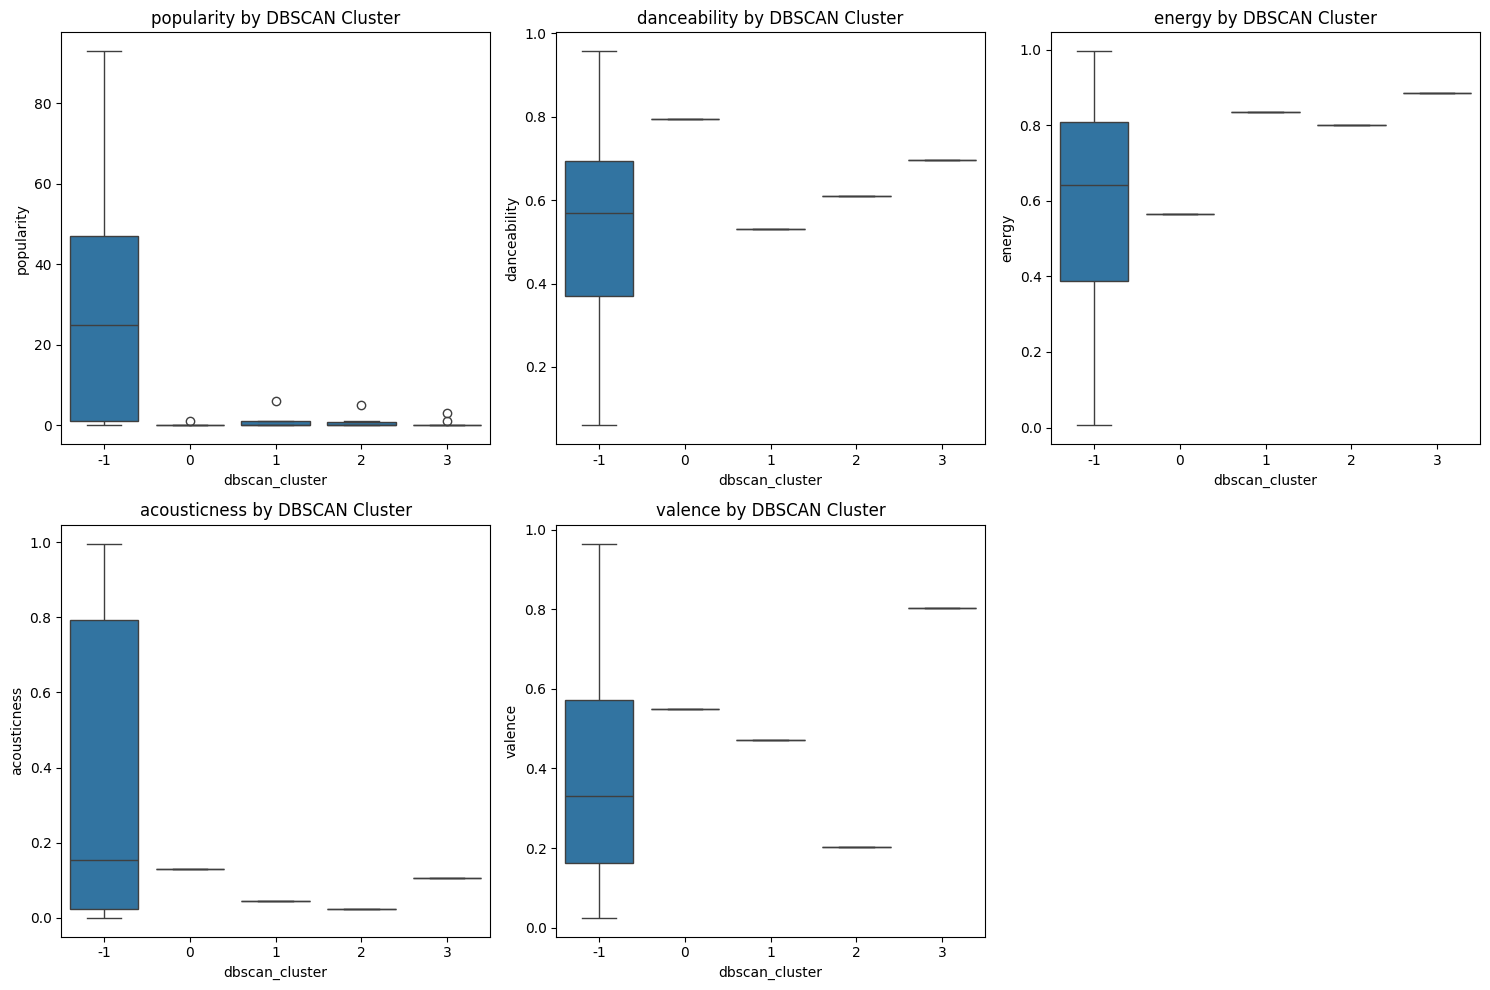

Number of points in each DBSCAN cluster (including noise points labeled as -1):
-1    1450
 3      16
 1      13
 0      11
 2      10
Name: count, dtype: int64


In [46]:
# Apply DBSCAN
dbscan_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dbscan', DBSCAN(eps=0.5, min_samples=10)),  # Adjust eps based on k-distance graph
])


dbscan_labels = dbscan_pipe.fit_predict(df.drop('kmeans_cluster', axis=1))
df['dbscan_cluster'] = dbscan_labels

# Analyze clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['popularity', 'danceability', 'energy', 'acousticness', 'valence']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='dbscan_cluster', y=feature, data=df)
    plt.title(f'{feature} by DBSCAN Cluster')
plt.tight_layout()
plt.show()

print("Number of points in each DBSCAN cluster (including noise points labeled as -1):")
print(pd.Series(dbscan_labels).value_counts())

### Visualizing DBSCAN Clusters with PCA

This cell visualizes DBSCAN results in 2D space:
- Uses the same PCA representation as before
- Shows how DBSCAN identifies clusters differently from K-Means
- Noise points are visible as cluster -1

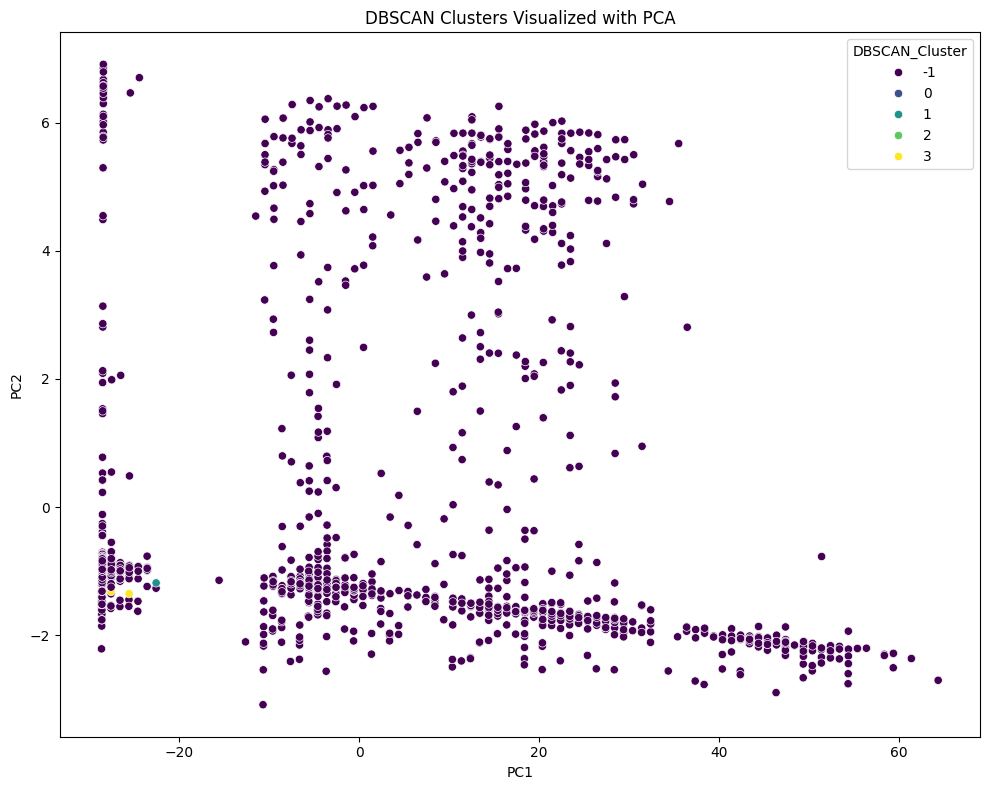

In [47]:
pca_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=pca_df, palette='viridis')
plt.title('DBSCAN Clusters Visualized with PCA')
plt.tight_layout()
plt.show()

**DBSCAN PCA Visualization Analysis**:

The visualization reveals that DBSCAN has identified several distinct clusters beyond just noise:

1. **Cluster 0 (Purple)**: The majority of points, forming the main bulk of the data
   - Occupies most of the PCA space
   - Corresponds to the mainstream or most common tracks in the dataset

2. **Other Clusters (Various Colors)**: Small groups of points scattered throughout
   - These represent tightly grouped sets of similar tracks
   - The algorithm identified these as having sufficient density to form distinct clusters
   - They appear as small dots of different colors (teal, green, yellow)

**Comparing DBSCAN vs K-Means Results**:

1. **Fundamental Difference**:
   - K-Means: Divided all data into 3 balanced clusters
   - DBSCAN: Found one large main cluster and several small, dense groups

2. **Interpretation**:
   - DBSCAN identified the core body of "typical" music (Cluster 0)
   - The smaller clusters likely represent niche genres or unique musical styles
   - This approach highlights outliers and special cases rather than forcing broad categorization

3. **Practical Applications**:
   - DBSCAN results could be useful for:
     - Identifying unique or unusual tracks
     - Finding niche genres
     - Detecting outliers in music collections
   - K-Means results are better for:
     - General music categorization
     - Creating balanced playlists
     - Understanding broad music trends

The DBSCAN visualization shows that while most music falls into a general category, there are distinct pockets of specialized music that form their own tight clusters.

# Classification

We chose to use four different classifiers:
1. SVM
2. CatBoost
3. KNN
4. Random Forest

### Data Prep

In [ ]:
df.drop('kmeans_cluster', axis=1, inplace=True)
df.drop('dbscan_cluster', axis=1, inplace=True)

# We create a binary target 'median'. This is the median popularity.
# Anything above this median is labeled as 1, anything below is it labeled as 0.
median = df['popularity'].median()
y, X = df['popularity'].map(lambda x: 1 if x >= median else 0), df.drop('popularity', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## SVM

In [49]:
svm_pipe = Pipeline(steps=[('preprocess', preprocessing_pipe), ('svm', svm.SVC(probability=True))])
svm_pipe

/home/euan/Uni/cs4168-Project/.venv/lib64/python3.13/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['speechiness', 'explicit',
                                                   'liveness',
                                                   'instrumentalness']),
                                                 ('outliers_zeros',
                                                  Pipeline(steps=[('cubic_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['acousticness']),
                                                 ('non_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['tempo', 'valence', 'key',
                                                   'danceability', 'mode',
                                                   'energy', 'loudness',
                                                   'time_signature'])])),
                ('svm', SVC(probability=True))])

In [50]:
param_grid = {
    'svm__C': [0.1, 1, 10],  
    'svm__gamma': [0.001, 0.01, 0.1], 
    'svm__kernel': ['rbf', 'linear', 'poly']
}

search = GridSearchCV(svm_pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.640:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}


## CatBoost

In [51]:
cat_pipe = Pipeline(steps=[('preprocess', preprocessing_pipe), ('cat', CatBoostClassifier(verbose=0))])
cat_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['speechiness', 'explicit',
                                                   'liveness',
                                                   'instrumentalness']),
                                                 ('outliers_zeros',
                                                  Pipeline(steps=[('cubic_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['acousticness']),
                                                 ('non_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['tempo', 'valence', 'key',
                                                   'danceability', 'mode',
                                                   'energy', 'loudness',
                                                   'time_signature'])])),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x7fdf5ad83cb0>)])

In [52]:
param_grid = {
    'cat__depth': [4, 6, 8],  
    'cat__learning_rate': [0.001, 0.01, 0.1], 
    'cat__iterations': [100, 200, 300]
    }

search = GridSearchCV(cat_pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

CAT_best_params = search.best_params_
CAT_best_model = search.best_estimator_

Best CV score = 0.711:
Best parameters:  {'cat__depth': 8, 'cat__iterations': 300, 'cat__learning_rate': 0.1}


## KNN

In [53]:
knn_pipe = Pipeline(steps=[('preprocess', preprocessing_pipe), ('knn', KNeighborsClassifier())])
knn_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['speechiness', 'explicit',
                                                   'liveness',
                                                   'instrumentalness']),
                                                 ('outliers_zeros',
                                                  Pipeline(steps=[('cubic_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['acousticness']),
                                                 ('non_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['tempo', 'valence', 'key',
                                                   'danceability', 'mode',
                                                   'energy', 'loudness',
                                                   'time_signature'])])),
                ('knn', KNeighborsClassifier())])

In [54]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
search = GridSearchCV(knn_pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_


Best CV score = 0.663:
Best parameters:  {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


## Random Forest (RF)

In [55]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessing_pipe), ('classifier', RandomForestClassifier(random_state=42))])

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Grid search for Random Forest
search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1' , n_jobs=-1)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.731:
Best parameters:  {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


## Evaluating

In [56]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

Using the function given in the labs, we evaluate each models performance on:  
- Accuracy
- Precision
- Recall
- F1 Score
- ROC curve
- AUC

In [57]:
def evaluate_model(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    _predicted_values = model.predict(X_test)
        
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [58]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
CAT_accuracy, CAT_precision, CAT_recall, CAT_f1_score, CAT_tpr, CAT_auc = evaluate_model(X_test, y_test, CAT_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)


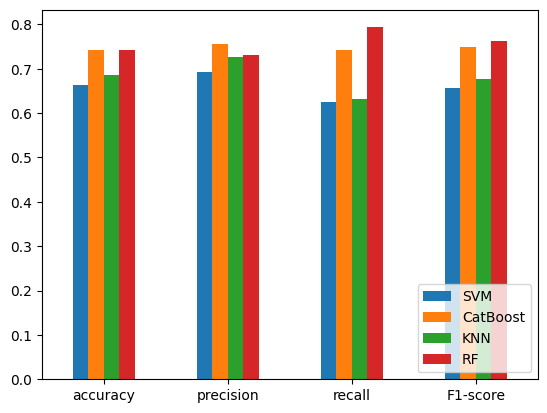

In [59]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
CAT_metrics = np.array([CAT_accuracy, CAT_precision, CAT_recall, CAT_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'CatBoost': CAT_metrics, 'KNN': KNN_metrics, 'RF': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

#### Graph Summary

1. CatBoost is the best performing classifier, beating the others in `accuracy`, `recall`, and `F1-Score`, and only narrowly behind KNN in `precision`.
2. KNN has the highest `precision`, but has the lowest `recall`.
3. Random Forest (FR) performs consistently well across all metrics, only slightly behind CatBoost in all.
4. SVM performs the worst in all metrics, bar `recall` in which is only slightly ahead of KNN.

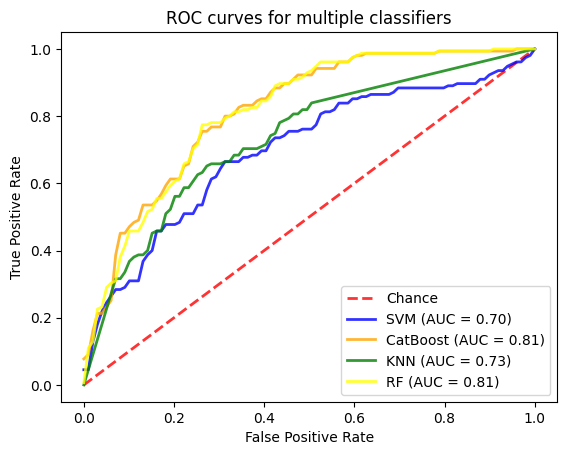

In [60]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, CAT_tpr[0,:], lw=2, color='orange', label='CatBoost (AUC = %0.2f)' % (CAT_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='yellow', label='RF (AUC = %0.2f)' % (RF_auc), alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

#### ROC Summary

1. CatBoost and Random Forest are tied for the best AUC (0.79), both performing very well.
2. KNN performs alright with an AUC of 0.72, not the worst, but not the best.
3. SVM is the worst performing again, with an AUC of 0.68.
4. Its worth noting that all classifiers perform better than random guessing.

## Overall Summary

CatBoost was the best performing classifier in almost all metrics.

This is likely due to the collection of several reasons.

1. CatBoost is very efficient at handling non-linear data.
Music is extremely complex, and many different factors are at play.

2. CatBoost is also good at dealing with noise.
Columns like `liveness` might have added unnecessary noise into the data.

3. CatBoost has built in regularisation techniques.
This helps reduce overfitting, leading to better results.


#### 